# Credit Card Fraud Detection — Final Project
## Exploratory Data Analysis & Data Preparation

**Team:** Nadezhda Shiroglazova, Prathamesh Nehete, Sheng Hu  
**Course:** Practical Machine Learning
**Date:** February 2026  
**Dataset:** [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) (Kaggle, MLG-ULB)

---

### Management / Research Question

Can we reliably identify fraudulent credit card transactions from anonymized
transaction data, and what patterns distinguish fraud from legitimate purchases?

Credit card fraud is a multi-billion-dollar global problem. According to the
Nilson Report (2022), global card fraud losses exceeded 32 billion in 2021 and
are projected to surpass 43 billion by 2026. For financial institutions,
undetected fraud erodes profit margins and regulatory standing. For consumers,
it causes financial disruption, emotional distress, and erosion of trust in
digital payment systems. For merchants, chargebacks from fraudulent
transactions cost an average of 2.5 times the transaction value when accounting
for lost goods, fees, and operational overhead (LexisNexis Risk Solutions 2023).

The challenge is acute because fraud is extraordinarily rare — in this dataset,
only 0.172% of transactions are fraudulent. This extreme imbalance means that
naive detection systems that simply approve every transaction would achieve
99.83% accuracy while catching zero fraud. Effective detection therefore requires
models and metrics that are specifically designed for needle-in-a-haystack
problems, prioritizing recall (catching fraud) and precision (avoiding false
alarms that block legitimate customers) over raw accuracy.

The dataset used here was collected by the Machine Learning Group at Université
Libre de Bruxelles (ULB) and Worldline, containing 284,807 credit card
transactions from European cardholders over two days in September 2013. Due to
confidentiality, 28 of the 30 features (V1–V28) have been pre-transformed via
Principal Component Analysis (PCA), making them anonymous but also orthogonal
by construction — a property that fundamentally changes the preprocessing
strategy compared to raw financial data (Dal Pozzolo et al. 2015). The remaining
two features, Time (seconds since first transaction) and Amount (transaction
value), are the only interpretable variables available for domain-driven feature
engineering.

This notebook focuses on thorough exploratory data analysis and careful data
preparation, establishing a clean, well-understood foundation for downstream
modeling. Every preprocessing decision is made with data leakage prevention as
a first-order concern: the data is split before any transformation, and all
statistics are computed exclusively from the training partition.

**References**

- Dal Pozzolo, A., O. Caelen, R. A. Johnson, and G. Bontempi. 2015. "Calibrating Probability with Undersampling for Unbalanced Classification." *IEEE Symposium Series on Computational Intelligence*, 159–166.
- LexisNexis Risk Solutions. 2023. *True Cost of Fraud Study*. Atlanta: LexisNexis.
- Nilson Report. 2022. "Global Card Fraud Losses." Issue 1209.

---
# 1. Setup and Data Loading

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import skew, kurtosis, iqr
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

SEED = 42
np.random.seed(SEED)


/Users/nadia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(f"\nDataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}   Columns: {df.shape[1]}")
print(f"\nColumn names:\n{df.columns.tolist()}")


Dataset shape: (284807, 31)
Rows: 284,807   Columns: 31

Column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0000,-1.3598,-0.0728,2.5363,1.3782,-0.3383,0.4624,0.2396,0.0987,0.3638,0.0908,-0.5516,-0.6178,-0.9914,-0.3112,1.4682,-0.4704,0.2080,0.0258,0.4040,0.2514,-0.0183,0.2778,-0.1105,0.0669,0.1285,-0.1891,0.1336,-0.0211,149.6200,0
1,0.0000,1.1919,0.2662,0.1665,0.4482,0.0600,-0.0824,-0.0788,0.0851,-0.2554,-0.1670,1.6127,1.0652,0.4891,-0.1438,0.6356,0.4639,-0.1148,-0.1834,-0.1458,-0.0691,-0.2258,-0.6387,0.1013,-0.3398,0.1672,0.1259,-0.0090,0.0147,2.6900,0
2,1.0000,-1.3584,-1.3402,1.7732,0.3798,-0.5032,1.8005,0.7915,0.2477,-1.5147,0.2076,0.6245,0.0661,0.7173,-0.1659,2.3459,-2.8901,1.1100,-0.1214,-2.2619,0.5250,0.2480,0.7717,0.9094,-0.6893,-0.3276,-0.1391,-0.0554,-0.0598,378.6600,0
3,1.0000,-0.9663,-0.1852,1.7930,-0.8633,-0.0103,1.2472,0.2376,0.3774,-1.3870,-0.0550,-0.2265,0.1782,0.5078,-0.2879,-0.6314,-1.0596,-0.6841,1.9658,-1.2326,-0.2080,-0.1083,0.0053,-0.1903,-1.1756,0.6474,-0.2219,0.0627,0.0615,123.5000,0
4,2.0000,-1.1582,0.8777,1.5487,0.4030,-0.4072,0.0959,0.5929,-0.2705,0.8177,0.7531,-0.8228,0.5382,1.3459,-1.1197,0.1751,-0.4514,-0.2370,-0.0382,0.8035,0.4085,-0.0094,0.7983,-0.1375,0.1413,-0.2060,0.5023,0.2194,0.2152,69.9900,0


In [6]:
print(df.dtypes.value_counts())
print(f"\nAll numeric: {df.select_dtypes(include=[np.number]).shape[1] == df.shape[1]}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Memory usage:   {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

float64    30
int64       1
Name: count, dtype: int64

All numeric: True
Missing values: 0
Duplicate rows: 1081
Memory usage:   70.6 MB


In [7]:
print(f"\nValue counts:")
print(df['Class'].value_counts())
print(f"\nPercentages:")
print(df['Class'].value_counts(normalize=True).mul(100).round(4))
print(f"\nFraud rate: {df['Class'].mean() * 100:.4f}%")
print(f"Imbalance ratio: 1 : {int((1 - df['Class'].mean()) / df['Class'].mean())}")


Value counts:
Class
0    284315
1       492
Name: count, dtype: int64

Percentages:
Class
0   99.8273
1    0.1727
Name: proportion, dtype: float64

Fraud rate: 0.1727%
Imbalance ratio: 1 : 577


---
# 2. Initial Exploratory Data Analysis

### Dataset Context

Features V1–V28 are principal components obtained via PCA from the original
(confidential) transaction features. This has critical implications:

1. V1–V28 are orthogonal by construction — there should be near-zero
   correlation between them. If we find high correlations, something is wrong.
2. V1–V28 are already centered and scaled — they do not need StandardScaler.
3. Feature names are anonymous — we cannot do domain-driven feature engineering
   on V-features. Our engineering is limited to `Time` and `Amount`.
4. No multicollinearity removal is needed — PCA components are independent.

The only raw (non-PCA) features are:
- Time - seconds elapsed since the first transaction in the dataset
- Amount -  the transaction amount in euros

In [8]:
desc = df.describe().T
desc['range'] = desc['max'] - desc['min']
desc['iqr'] = df.apply(lambda x: iqr(x))
print(desc[['mean', '50%', 'std', 'min', 'max', 'range', 'iqr']].to_string())

             mean        50%        std       min         max       range        iqr
Time   94813.8596 84692.0000 47488.1460    0.0000 172792.0000 172792.0000 85119.0000
V1         0.0000     0.0181     1.9587  -56.4075      2.4549     58.8624     2.2360
V2         0.0000     0.0655     1.6513  -72.7157     22.0577     94.7735     1.4023
V3        -0.0000     0.1798     1.5163  -48.3256      9.3826     57.7081     1.9176
V4         0.0000    -0.0198     1.4159   -5.6832     16.8753     22.5585     1.5920
V5         0.0000    -0.0543     1.3802 -113.7433     34.8017    148.5450     1.3035
V6         0.0000    -0.2742     1.3323  -26.1605     73.3016     99.4621     1.1669
V7        -0.0000     0.0401     1.2371  -43.5572    120.5895    164.1467     1.1245
V8         0.0000     0.0224     1.1944  -73.2167     20.0072     93.2239     0.5360
V9        -0.0000    -0.0514     1.0986  -13.4341     15.5950     29.0291     1.2402
V10        0.0000    -0.0929     1.0888  -24.5883     23.7451    

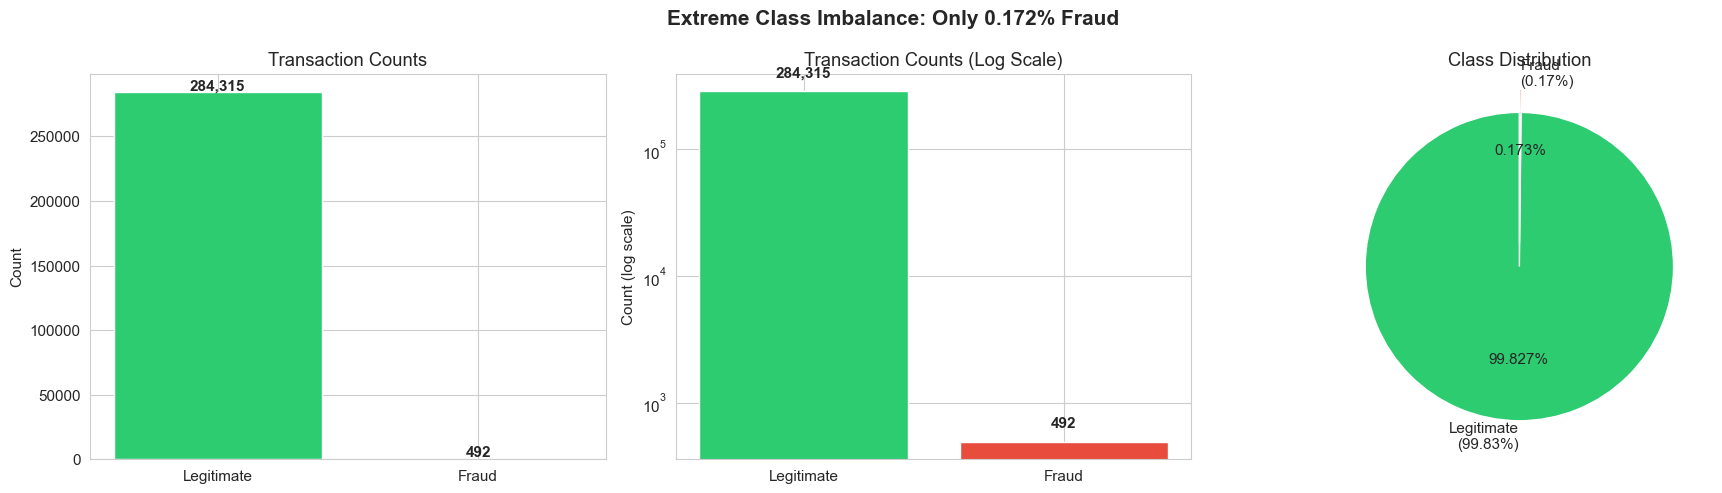

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Legitimate', 'Fraud'], counts.values, color=colors)
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Counts')
for bar, val in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width() / 2, val + 2000,
                 f'{val:,}', ha='center', fontweight='bold', fontsize=11)

axes[1].bar(['Legitimate', 'Fraud'], counts.values, color=colors)
axes[1].set_yscale('log')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_title('Transaction Counts (Log Scale)')
for i, val in enumerate(counts.values):
    axes[1].text(i, val * 1.3, f'{val:,}', ha='center', fontweight='bold')

axes[2].pie(counts.values, labels=['Legitimate\n(99.83%)', 'Fraud\n(0.17%)'],
            colors=colors, startangle=90, explode=(0, 0.15),
            autopct='%1.3f%%', textprops={'fontsize': 11})
axes[2].set_title('Class Distribution')

plt.suptitle('Extreme Class Imbalance: Only 0.172% Fraud',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

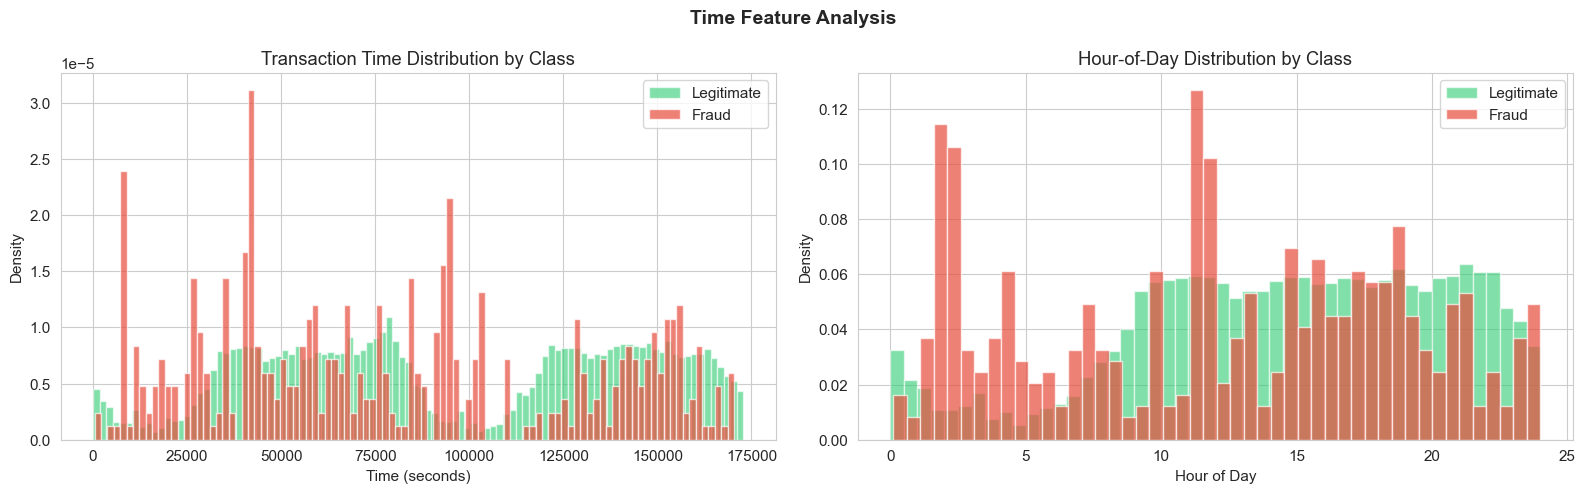

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(df[df['Class'] == 0]['Time'], bins=100, alpha=0.6,
             color='#2ecc71', label='Legitimate', density=True)
axes[0].hist(df[df['Class'] == 1]['Time'], bins=100, alpha=0.7,
             color='#e74c3c', label='Fraud', density=True)
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Density')
axes[0].set_title('Transaction Time Distribution by Class')
axes[0].legend()

df['Hour'] = (df['Time'] / 3600) % 24
axes[1].hist(df[df['Class'] == 0]['Hour'], bins=48, alpha=0.6,
             color='#2ecc71', label='Legitimate', density=True)
axes[1].hist(df[df['Class'] == 1]['Hour'], bins=48, alpha=0.7,
             color='#e74c3c', label='Fraud', density=True)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Density')
axes[1].set_title('Hour-of-Day Distribution by Class')
axes[1].legend()

plt.suptitle('Time Feature Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

df.drop('Hour', axis=1, inplace=True)

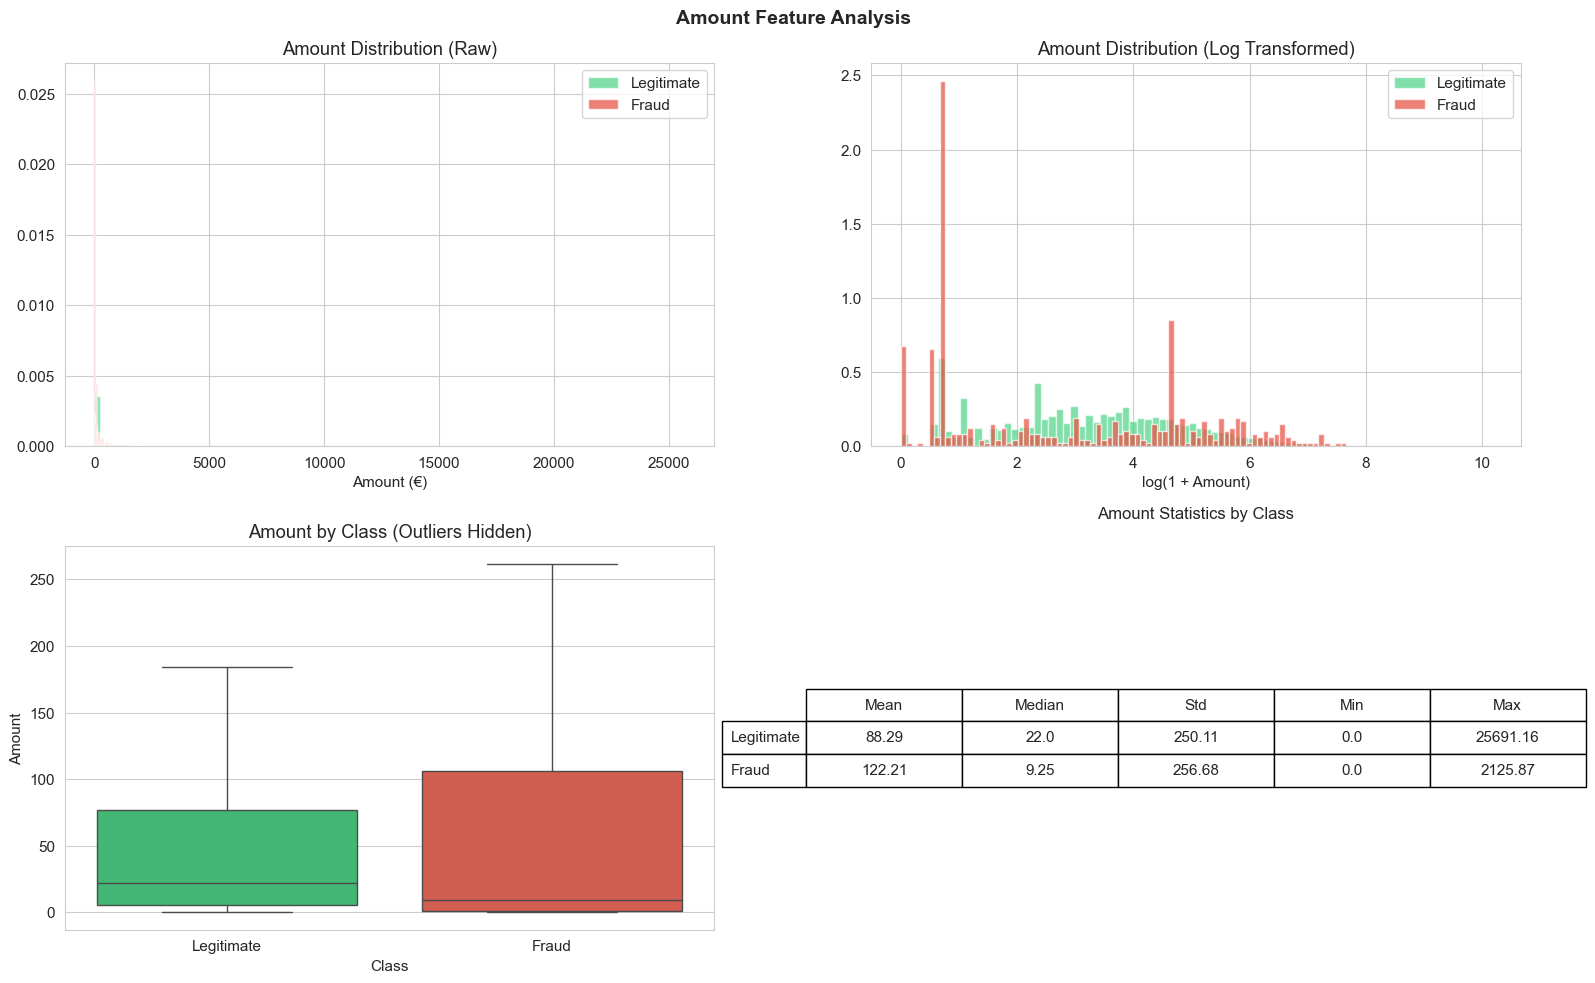


Amount statistics:
  Legitimate — Mean: €88.29, Median: €22.00
  Fraud      — Mean: €122.21, Median: €9.25


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].hist(df[df['Class'] == 0]['Amount'], bins=100, alpha=0.6,
                color='#2ecc71', label='Legitimate', density=True)
axes[0, 0].hist(df[df['Class'] == 1]['Amount'], bins=100, alpha=0.7,
                color='#e74c3c', label='Fraud', density=True)
axes[0, 0].set_xlabel('Amount (€)')
axes[0, 0].set_title('Amount Distribution (Raw)')
axes[0, 0].legend()

axes[0, 1].hist(np.log1p(df[df['Class'] == 0]['Amount']), bins=80, alpha=0.6,
                color='#2ecc71', label='Legitimate', density=True)
axes[0, 1].hist(np.log1p(df[df['Class'] == 1]['Amount']), bins=80, alpha=0.7,
                color='#e74c3c', label='Fraud', density=True)
axes[0, 1].set_xlabel('log(1 + Amount)')
axes[0, 1].set_title('Amount Distribution (Log Transformed)')
axes[0, 1].legend()

sns.boxplot(x='Class', y='Amount', data=df, ax=axes[1, 0],
            hue='Class', palette={0: '#2ecc71', 1: '#e74c3c'},
            showfliers=False, legend=False)
axes[1, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[1, 0].set_title('Amount by Class (Outliers Hidden)')

amount_stats = df.groupby('Class')['Amount'].describe()
axes[1, 1].axis('off')
table = axes[1, 1].table(
    cellText=amount_stats[['mean', '50%', 'std', 'min', 'max']].round(2).values,
    rowLabels=['Legitimate', 'Fraud'],
    colLabels=['Mean', 'Median', 'Std', 'Min', 'Max'],
    loc='center', cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
axes[1, 1].set_title('Amount Statistics by Class', fontsize=12, pad=20)

plt.suptitle('Amount Feature Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nAmount statistics:")
print(f"  Legitimate — Mean: €{df[df['Class']==0]['Amount'].mean():.2f}, "
      f"Median: €{df[df['Class']==0]['Amount'].median():.2f}")
print(f"  Fraud      — Mean: €{df[df['Class']==1]['Amount'].mean():.2f}, "
      f"Median: €{df[df['Class']==1]['Amount'].median():.2f}")

In [12]:
skew_kurt = pd.DataFrame({
    'Skewness': df.drop('Class', axis=1).apply(skew),
    'Kurtosis': df.drop('Class', axis=1).apply(kurtosis),
    '|Skewness|': df.drop('Class', axis=1).apply(lambda x: abs(skew(x))),
}).sort_values('|Skewness|', ascending=False)

print(skew_kurt.head(20).to_string())

print(f"\nFeatures with |skewness| > 2:  {(skew_kurt['|Skewness|'] > 2).sum()}")
print(f"Features with kurtosis > 10:   {(skew_kurt['Kurtosis'] > 10).sum()}")
print(f"Features with kurtosis > 100:  {(skew_kurt['Kurtosis'] > 100).sum()}")

        Skewness  Kurtosis  |Skewness|
Amount   16.9776  845.0778     16.9776
V28      11.1920  933.3811     11.1920
V8       -8.5219  220.5831      8.5219
V23      -5.8751  440.0809      5.8751
V2       -4.6248   95.7714      4.6248
V17      -3.8449   94.7980      3.8449
V21       3.5930  207.2834      3.5930
V1       -3.2807   32.4861      3.2807
V7        2.5539  405.6003      2.5539
V5       -2.4259  206.9009      2.4259
V12      -2.2784   20.2415      2.2784
V3       -2.2401   26.6191      2.2401
V20      -2.0371  271.0113      2.0371
V14      -1.9952   23.8790      1.9952
V6        1.8266   42.6417      1.8266
V10       1.1871   31.9877      1.1871
V27      -1.1702  244.9849      1.1702
V16      -1.1010   10.4189      1.1010
V4        0.6763    2.6354      0.6763
V26       0.5767    0.9190      0.5767

Features with |skewness| > 2:  13
Features with kurtosis > 10:   18
Features with kurtosis > 100:  9


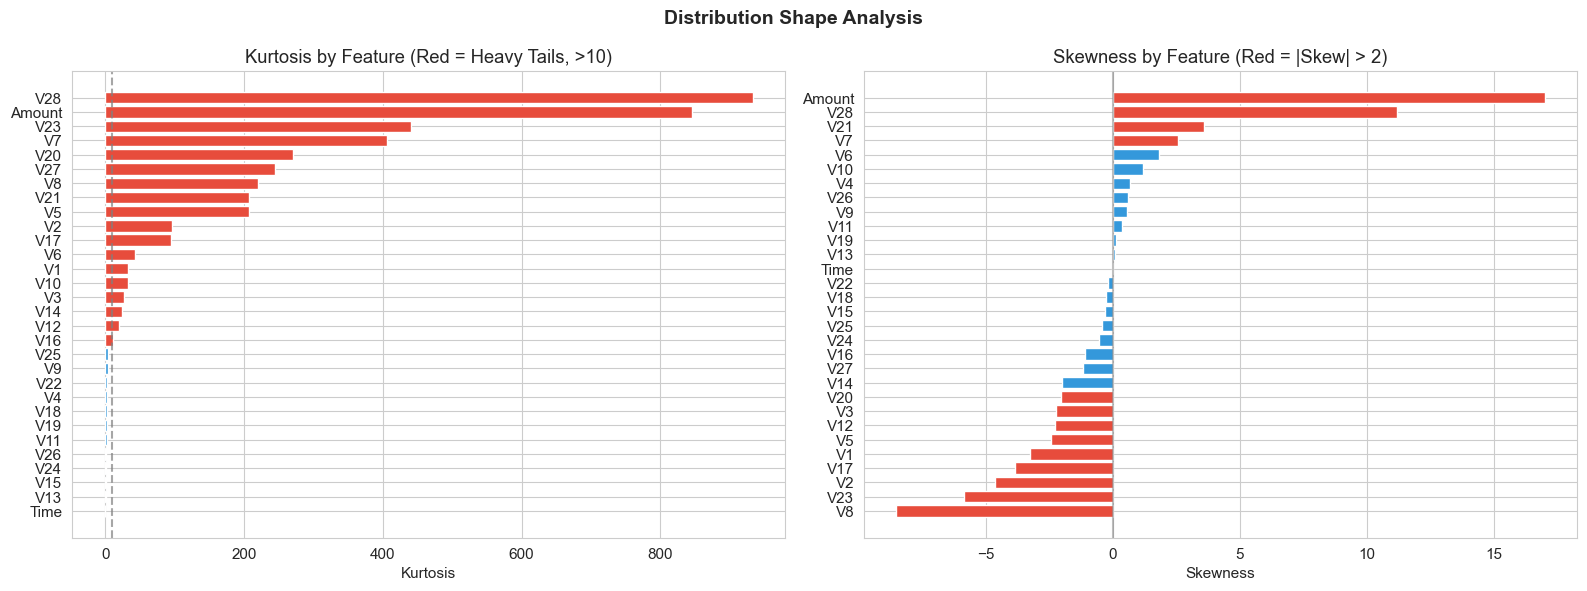

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

kurt_sorted = skew_kurt.sort_values('Kurtosis', ascending=False)
colors = ['#e74c3c' if k > 10 else '#3498db' for k in kurt_sorted['Kurtosis']]
axes[0].barh(kurt_sorted.index, kurt_sorted['Kurtosis'], color=colors)
axes[0].set_xlabel('Kurtosis')
axes[0].set_title('Kurtosis by Feature (Red = Heavy Tails, >10)')
axes[0].axvline(x=10, color='gray', linestyle='--', alpha=0.7)
axes[0].invert_yaxis()

skew_sorted = skew_kurt.sort_values('Skewness', ascending=False)
colors = ['#e74c3c' if abs(s) > 2 else '#3498db' for s in skew_sorted['Skewness']]
axes[1].barh(skew_sorted.index, skew_sorted['Skewness'], color=colors)
axes[1].set_xlabel('Skewness')
axes[1].set_title('Skewness by Feature (Red = |Skew| > 2)')
axes[1].axvline(x=0, color='gray', linestyle='-', alpha=0.5)
axes[1].invert_yaxis()

plt.suptitle('Distribution Shape Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# 3. Expanded EDA — V-Features and Correlations

Since V1–V28 are PCA components, they are anonymous. However, we can still
analyze which ones separate the fraud and legitimate classes, which ones have
outliers, and whether the expected orthogonality holds.

In [14]:
v_features = [f'V{i}' for i in range(1, 29)]

mean_diff = pd.DataFrame({
    'Legit_Mean': df[df['Class'] == 0][v_features].mean(),
    'Fraud_Mean': df[df['Class'] == 1][v_features].mean(),
    'Pooled_Std': df[v_features].std()
})
mean_diff['Standardized_Diff'] = (
    abs(mean_diff['Fraud_Mean'] - mean_diff['Legit_Mean']) / mean_diff['Pooled_Std']
)
mean_diff = mean_diff.sort_values('Standardized_Diff', ascending=False)

print(" V-Features Ranked by Class Separation \n")
print(mean_diff[['Standardized_Diff', 'Legit_Mean', 'Fraud_Mean']].to_string())

 V-Features Ranked by Class Separation 

     Standardized_Diff  Legit_Mean  Fraud_Mean
V17             7.8619      0.0115     -6.6658
V14             7.2854      0.0121     -6.9717
V12             6.2752      0.0108     -6.2594
V10             5.2227      0.0098     -5.6769
V16             4.7328      0.0072     -4.1399
V3              4.6466      0.0122     -7.0333
V7              4.5093      0.0096     -5.5687
V11             3.7295     -0.0066      3.8002
V4              3.2135     -0.0079      4.5420
V18             2.6846      0.0039     -2.2463
V1              2.4405      0.0083     -4.7719
V9              2.3535      0.0045     -2.5811
V5              2.2870      0.0055     -3.1512
V2              2.1983     -0.0063      3.6238
V6              1.0510      0.0024     -1.3977
V21             0.9732     -0.0012      0.7136
V19             0.8376     -0.0012      0.6807
V20             0.4838     -0.0006      0.3723
V8              0.4786     -0.0010      0.5706
V27             0.4

## 3.2  VISUALIZATION: Top 8 V-Features by Class Separation

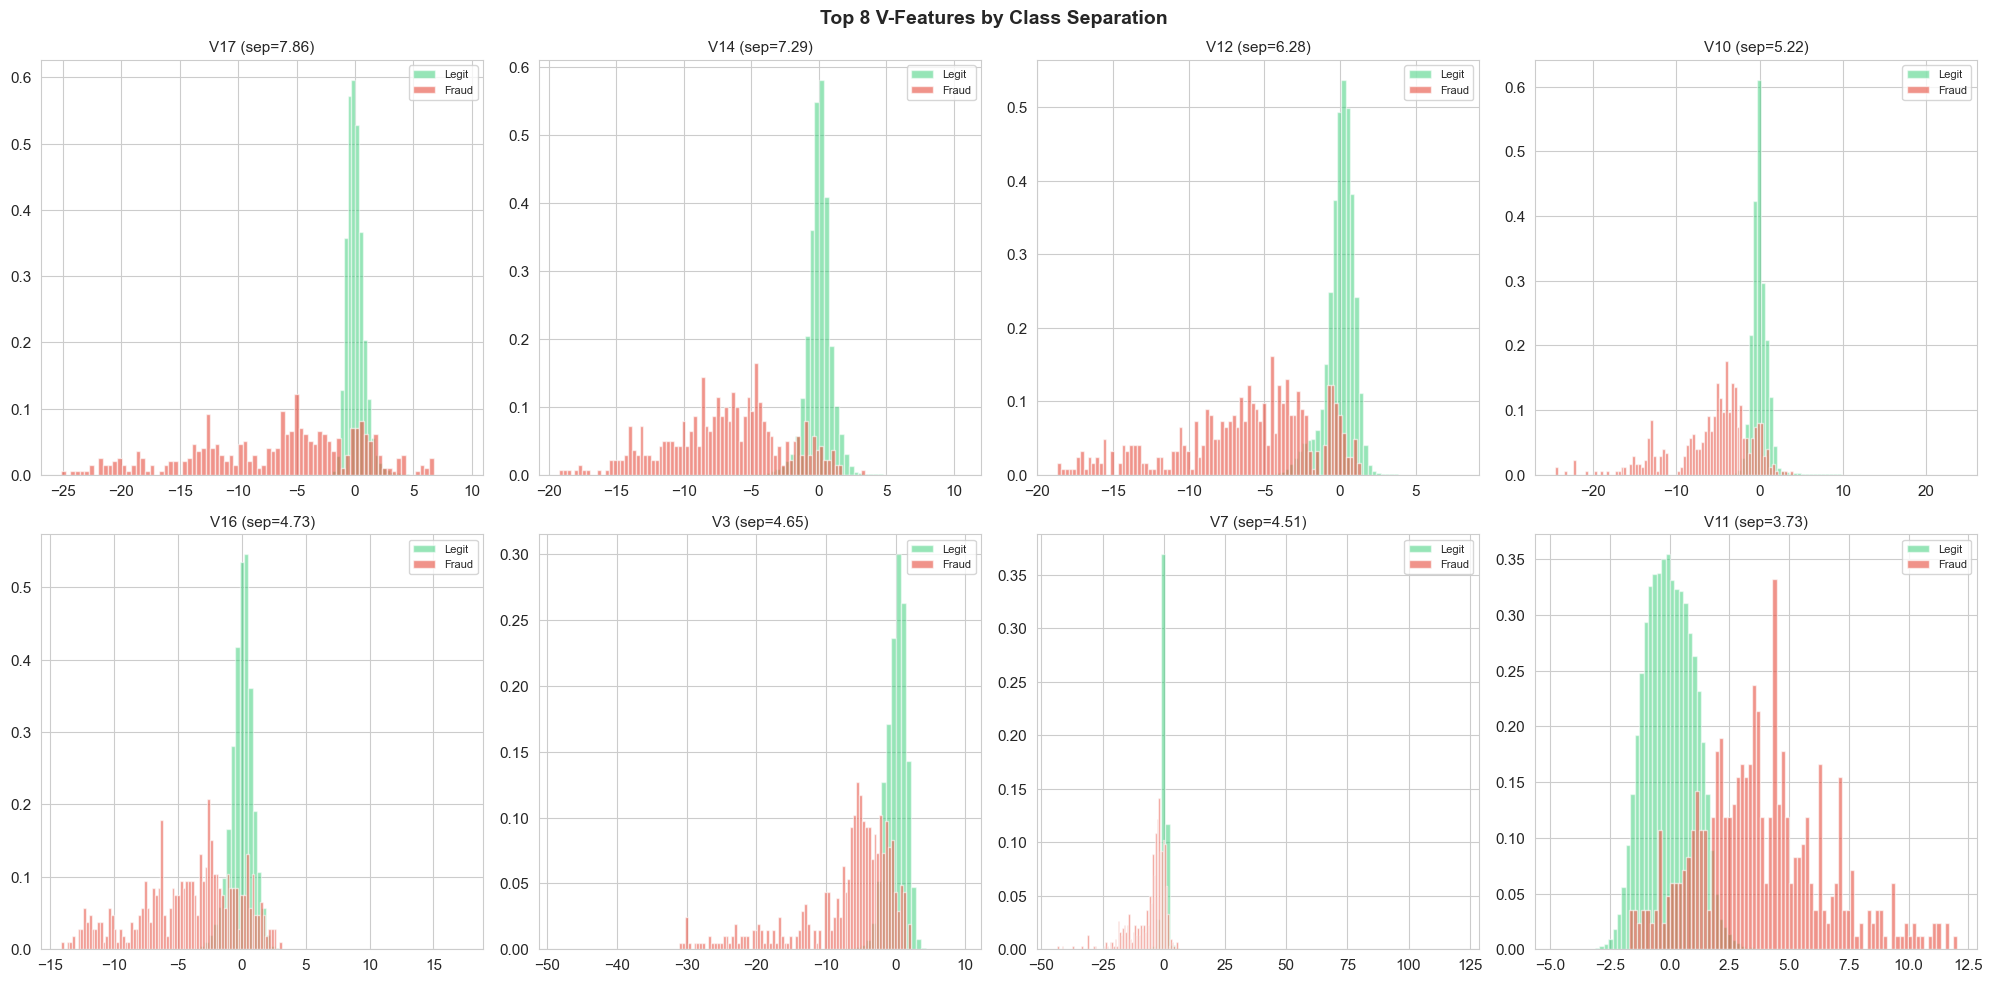

In [15]:
top8 = mean_diff.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for ax, feat in zip(axes.flatten(), top8):
    ax.hist(df[df['Class'] == 0][feat], bins=80, alpha=0.5,
            color='#2ecc71', label='Legit', density=True)
    ax.hist(df[df['Class'] == 1][feat], bins=80, alpha=0.6,
            color='#e74c3c', label='Fraud', density=True)
    diff = mean_diff.loc[feat, 'Standardized_Diff']
    ax.set_title(f'{feat} (sep={diff:.2f})', fontsize=11)
    ax.legend(fontsize=8)

plt.suptitle('Top 8 V-Features by Class Separation',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3  VISUALIZATION: Bottom 4 V-Features (Least Useful)

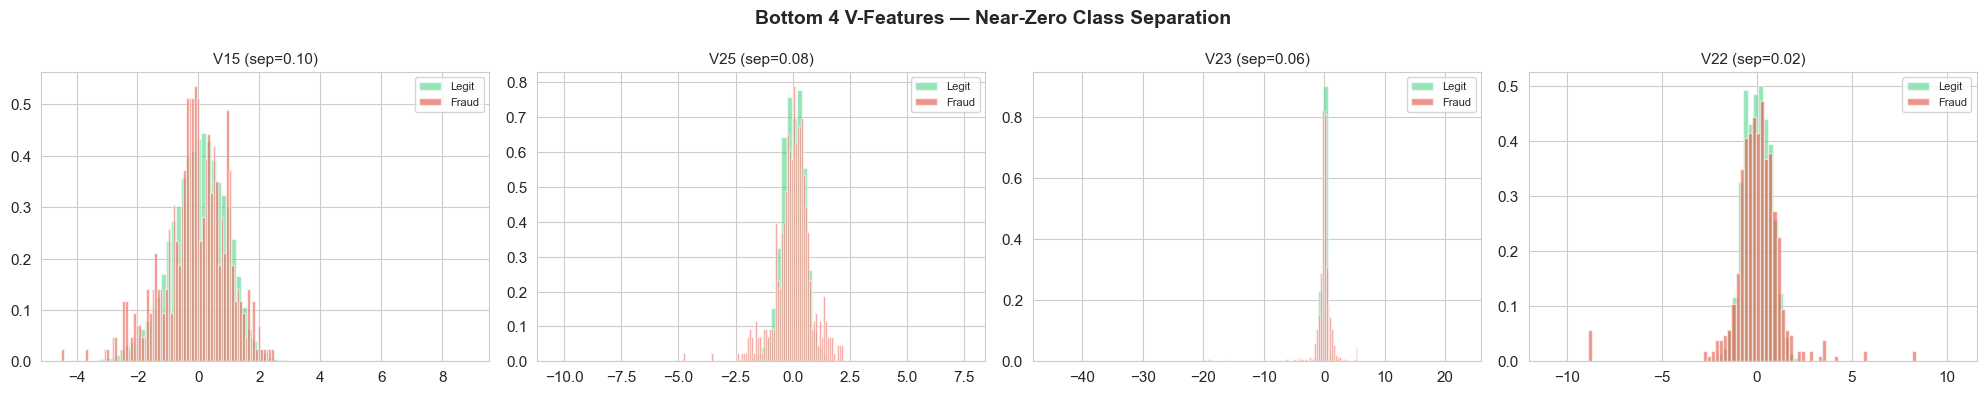

In [16]:
bottom4 = mean_diff.tail(4).index.tolist()

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, feat in zip(axes.flatten(), bottom4):
    ax.hist(df[df['Class'] == 0][feat], bins=80, alpha=0.5,
            color='#2ecc71', label='Legit', density=True)
    ax.hist(df[df['Class'] == 1][feat], bins=80, alpha=0.6,
            color='#e74c3c', label='Fraud', density=True)
    diff = mean_diff.loc[feat, 'Standardized_Diff']
    ax.set_title(f'{feat} (sep={diff:.2f})', fontsize=11)
    ax.legend(fontsize=8)

plt.suptitle('Bottom 4 V-Features — Near-Zero Class Separation',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Correlation matrix

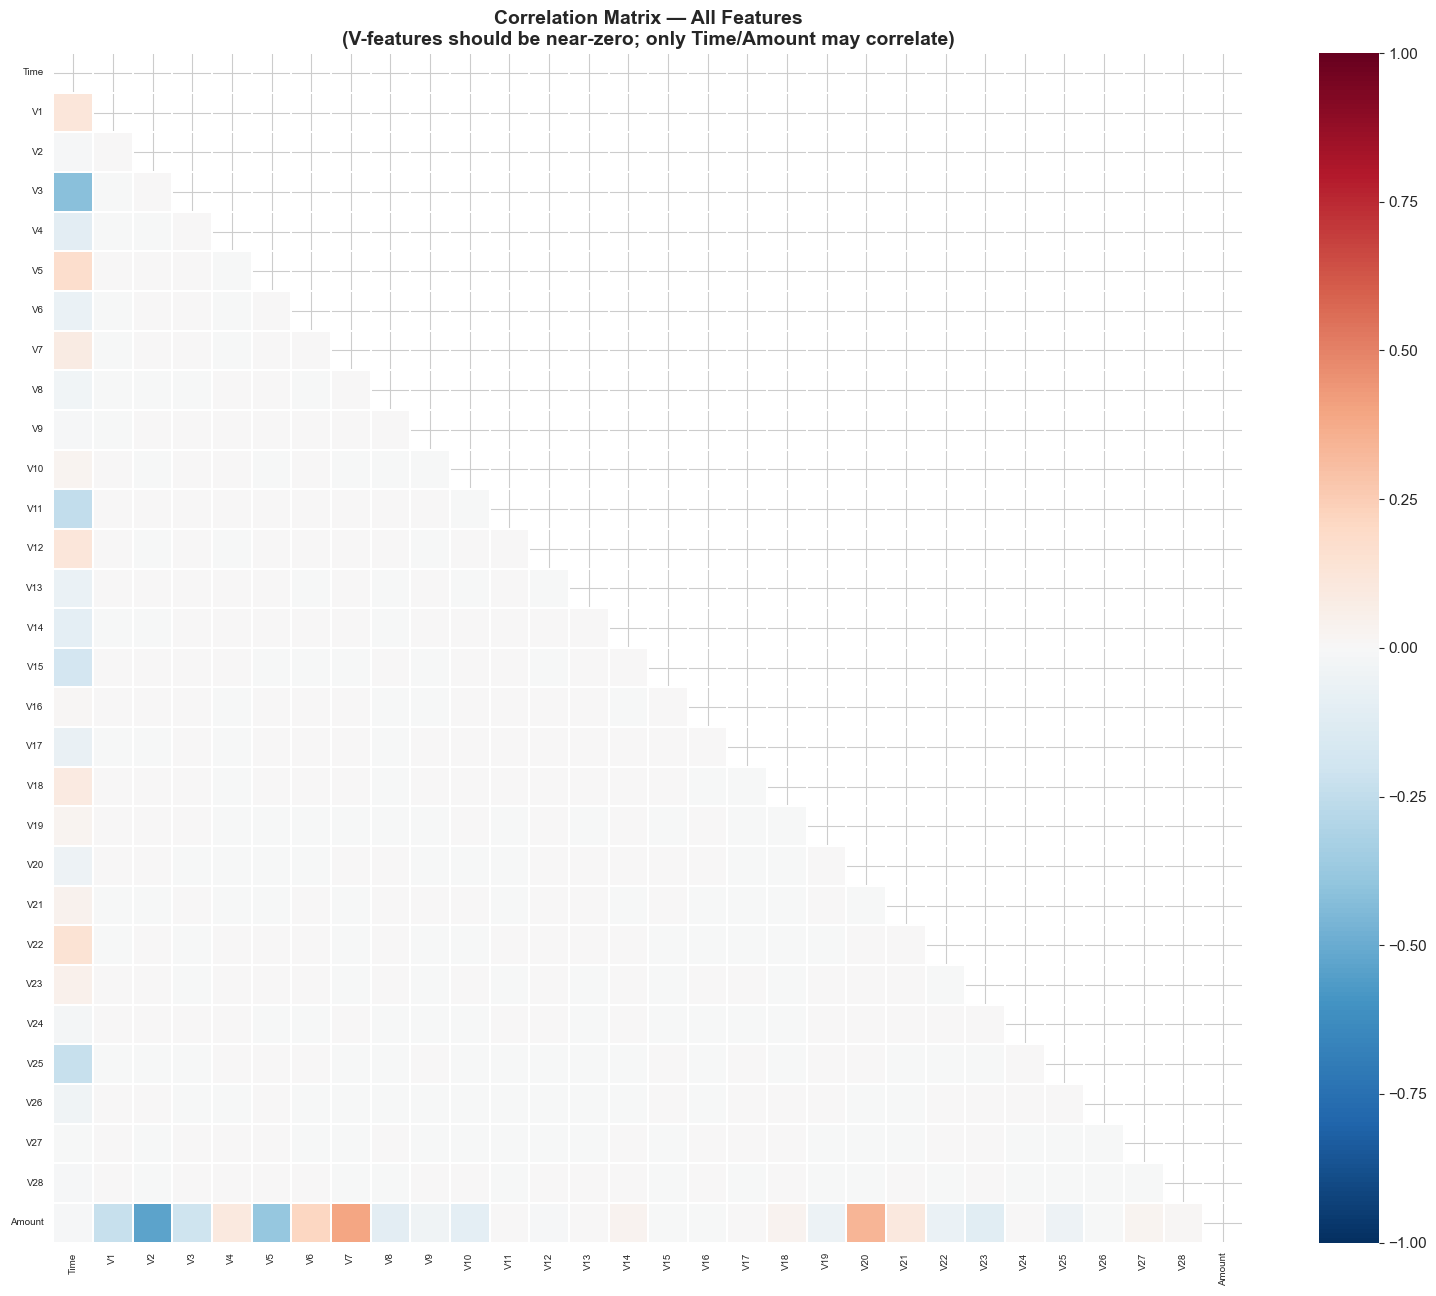


V-feature pairs with |correlation| > 0.3: 0
None


In [17]:
corr_matrix = df.drop('Class', axis=1).corr()

plt.figure(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, linewidths=0.1, square=True,
            xticklabels=True, yticklabels=True)
plt.title('Correlation Matrix — All Features\n'
          '(V-features should be near-zero; only Time/Amount may correlate)',
          fontsize=14, fontweight='bold')
plt.xticks(fontsize=7, rotation=90)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

# Check for unexpected correlations among V-features
v_corr = df[v_features].corr()
upper_v = v_corr.where(np.triu(np.ones(v_corr.shape), k=1).astype(bool))
high_corr_v = [(col, upper_v.index[i], upper_v.iloc[i][col])
               for col in upper_v.columns
               for i in range(len(upper_v))
               if abs(upper_v.iloc[i][col]) > 0.3]

print(f"\nV-feature pairs with |correlation| > 0.3: {len(high_corr_v)}")
if high_corr_v:
    for f1, f2, r in sorted(high_corr_v, key=lambda x: abs(x[2]), reverse=True)[:5]:
        print(f"  {f1} ↔ {f2}: {r:.4f}")
else:
    print("None")

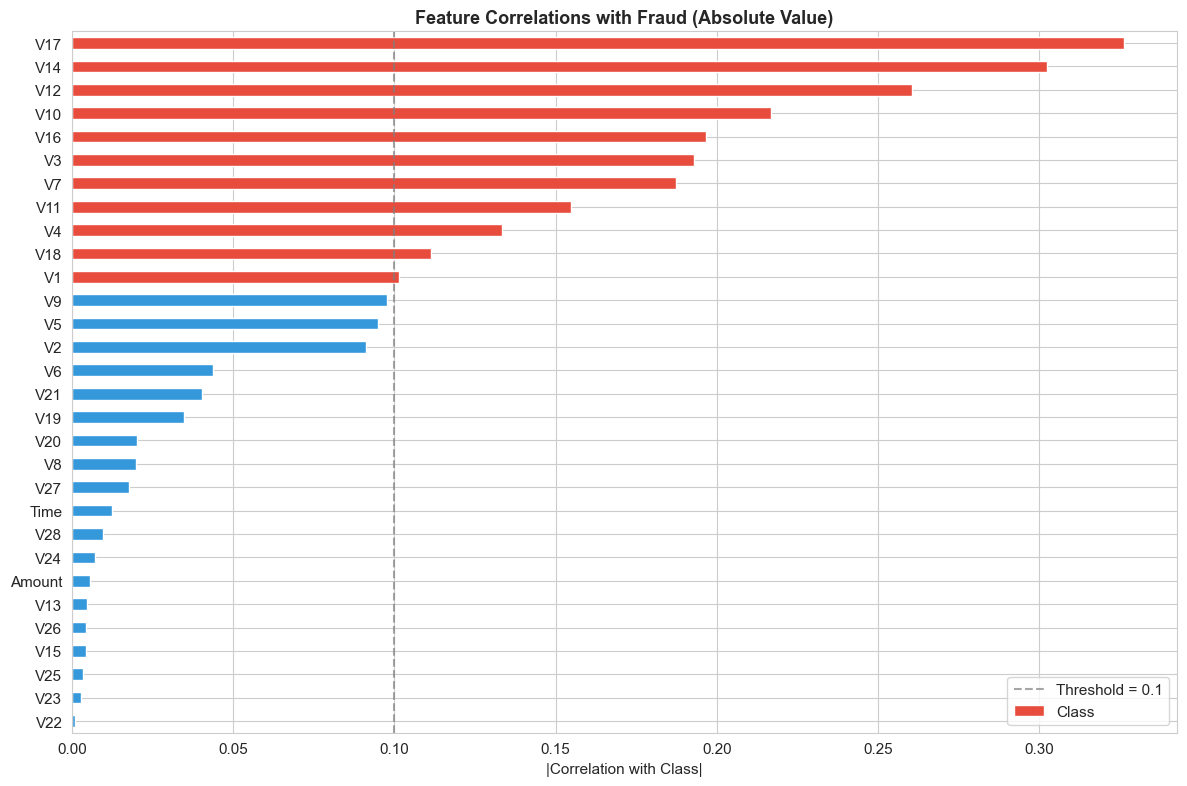


Top 10 features by |correlation| with fraud:
V17   0.3265
V14   0.3025
V12   0.2606
V10   0.2169
V16   0.1965
V3    0.1930
V7    0.1873
V11   0.1549
V4    0.1334
V18   0.1115


In [18]:
target_corr = df.corr()['Class'].drop('Class').abs().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#e74c3c' if c > 0.1 else '#3498db' for c in target_corr.values]
target_corr.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('|Correlation with Class|')
ax.set_title('Feature Correlations with Fraud (Absolute Value)',
             fontsize=13, fontweight='bold')
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.7, label='Threshold = 0.1')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 features by |correlation| with fraud:")
print(target_corr.head(10).to_string())

### Outlier analysis

Outlier Percentage by Feature (IQR × 3)

Amount   6.6505
V27      5.8018
V20      4.6997
V28      4.4146
V8       3.9623
V23      2.8563
V21      2.4346
V6       1.8922
V2       1.5635
V10      1.1264
V7       1.0713
V14      0.8444
V5       0.8149
V1       0.7001
V17      0.5088


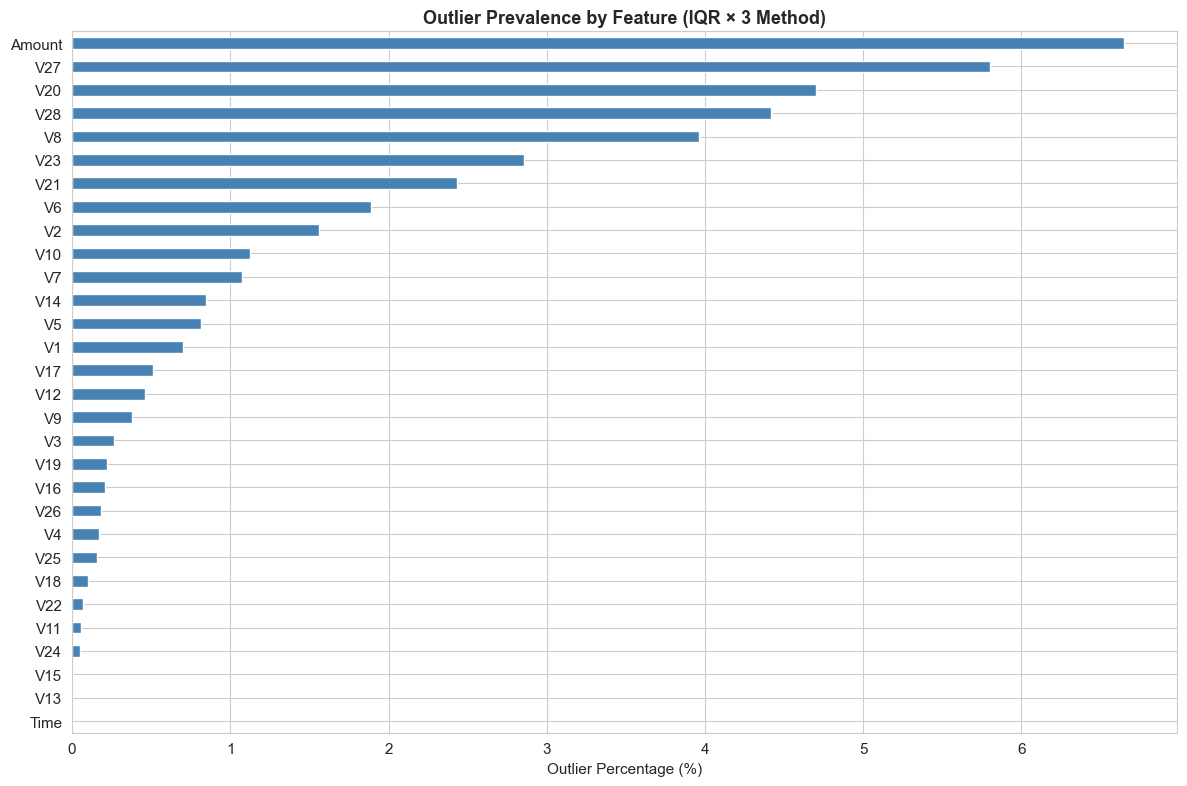

In [19]:
outlier_pct = pd.Series(dtype=float)
for col in df.drop('Class', axis=1).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr_val = q3 - q1
    lower = q1 - 3 * iqr_val
    upper = q3 + 3 * iqr_val
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_pct[col] = n_outliers / len(df) * 100

outlier_pct = outlier_pct.sort_values(ascending=False)

print("Outlier Percentage by Feature (IQR × 3)\n")
print(outlier_pct.head(15).to_string())

fig, ax = plt.subplots(figsize=(12, 8))
outlier_pct.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Outlier Percentage (%)')
ax.set_title('Outlier Prevalence by Feature (IQR × 3 Method)',
             fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [20]:
# ── 3.7  Duplicate Analysis ─────────────────────────────────────
n_dupes = df.duplicated().sum()
print(f"Duplicate rows: {n_dupes}")

if n_dupes > 0:
    # Check if duplicates are more likely to be fraud
    dupes = df[df.duplicated(keep=False)]
    dupe_fraud_rate = dupes['Class'].mean() * 100
    overall_fraud_rate = df['Class'].mean() * 100

    print(f"\nFraud rate in duplicates:     {dupe_fraud_rate:.2f}%")
    print(f"Fraud rate overall:           {overall_fraud_rate:.4f}%")
    print(f"\nDuplicate rows likely represent repeated legitimate transactions")
    print(f"(e.g., same amount at same merchant). We keep them as they are")
    print(f"genuine data points, not data errors.")
else:
    print("No duplicate rows found.")

Duplicate rows: 1081

Fraud rate in duplicates:     1.73%
Fraud rate overall:           0.1727%

Duplicate rows likely represent repeated legitimate transactions
(e.g., same amount at same merchant). We keep them as they are
genuine data points, not data errors.


### Hypotheses about Fraud Drivers

1. Certain V-features (especially those with high class separation) will be
   the primary fraud indicators. The PCA transformation captured latent
   patterns; the top-separating components likely encode transaction velocity,
   geographic anomalies, or merchant category signals.

2. Transaction Amount alone is a weak predictor. Fraudulent transactions
   span a wide range of amounts. However, extremely small "test charges"
   (e.g., < €1) and unusually large transactions may be more suspicious.

3. Time-of-day patterns will provide modest additional signal. Fraud may
   concentrate during off-peak hours when human monitoring is reduced.

### Data Risks Identified

1. Extreme class imbalance (0.172%): Even worse than the bankruptcy dataset
   (3.2%). Accuracy is completely meaningless here; we must use PR-AUC, recall,
   and F1 for the minority class.

2. PCA anonymization limits feature engineering: We cannot create
   domain-driven composite features from V1–V28 because we don't know what
   they represent. Engineering is limited to Time and Amount.

3. Temporal structure: Transactions are time-ordered. A naive random split
   might leak future information. However, since PCA has already obscured the
   temporal features, and we are using stratify on the target, a random
   stratified split is acceptable for this dataset.

# 4. Data Preparation and Feature Engineering

## 4.1 Train / Validation / Test Split (70 / 10 / 20)

We split before any preprocessing to prevent data leakage. Stratification
ensures the fraud rate is preserved across all partitions.

In [21]:
X = df.drop('Class', axis=1)
y = df['Class']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=SEED, stratify=y_temp
)

for name, X_part, y_part in [('Training', X_train, y_train),
                              ('Validation', X_val, y_val),
                              ('Test', X_test, y_test)]:
    n = len(y_part)
    n_fraud = y_part.sum()
    print(f"  {name:12s}: {n:>7,} rows ({n/len(df)*100:5.1f}%)  |  "
          f"Fraud: {n_fraud:>4} ({y_part.mean()*100:.4f}%)")

print(f"\n  Total:       {len(y_train)+len(y_val)+len(y_test):>7,}")

  Training    : 199,364 rows ( 70.0%)  |  Fraud:  345 (0.1731%)
  Validation  :  28,481 rows ( 10.0%)  |  Fraud:   49 (0.1720%)
  Test        :  56,962 rows ( 20.0%)  |  Fraud:   98 (0.1720%)

  Total:       284,807


## 4.2 Feature Engineering

Since V1–V28 are anonymous PCA components, our feature engineering is focused
on the two interpretable features: Time and Amount.

In [22]:
def engineer_features(data):
    data = data.copy()

    # 1. Hour of day (cyclical)
    # Time is seconds since first transaction; dataset spans ~2 days
    data['Hour'] = (data['Time'] / 3600) % 24

    # 2. Sin/Cos encoding of hour (captures cyclical nature)
    # WHY: Hour 23 is close to hour 0, but raw values are far apart.
    # Sin/cos encoding preserves this cyclical proximity.
    data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

    # 3. Is nighttime (off-peak hours: 11 PM - 6 AM)
    # WHY: Fraud may concentrate during off-peak hours.
    data['Is_Night'] = ((data['Hour'] >= 23) | (data['Hour'] < 6)).astype(int)

    # 4. Log-transformed Amount
    # WHY: Amount is extremely right-skewed (skewness ~16).
    # Log transform reduces skew and makes the distribution more normal,
    # which helps distance-based and split-based algorithms.
    data['Log_Amount'] = np.log1p(data['Amount'])

    # 5. Amount bins (small, medium, large, very large)
    # WHY: Captures non-linear relationship between amount and fraud risk.
    # Very small amounts may be "test charges" by fraudsters.
    # Bins are based on fixed thresholds, not data-dependent quantiles.
    data['Amount_Bin_Small'] = (data['Amount'] <= 5).astype(int)
    data['Amount_Bin_Large'] = (data['Amount'] > 500).astype(int)

    # Drop raw Hour (keep sin/cos representation)
    data.drop('Hour', axis=1, inplace=True)

    return data


X_train_eng = engineer_features(X_train)
X_val_eng = engineer_features(X_val)
X_test_eng = engineer_features(X_test)

new_cols = [c for c in X_train_eng.columns if c not in X_train.columns]
print(f"Engineered features: {new_cols}")
print(f"\nFeature count: {X_train.shape[1]} → {X_train_eng.shape[1]}")

print(f"\nEngineered feature statistics (training set):")
for col in new_cols:
    corr = np.corrcoef(X_train_eng[col], y_train)[0, 1]
    print(f"  {col:20s}  mean={X_train_eng[col].mean():.4f}  "
          f"std={X_train_eng[col].std():.4f}  corr_with_fraud={corr:.4f}")

Engineered features: ['Hour_Sin', 'Hour_Cos', 'Is_Night', 'Log_Amount', 'Amount_Bin_Small', 'Amount_Bin_Large']

Feature count: 30 → 36

Engineered feature statistics (training set):
  Hour_Sin              mean=-0.2673  std=0.6274  corr_with_fraud=0.0116
  Hour_Cos              mean=-0.1416  std=0.7175  corr_with_fraud=0.0056
  Is_Night              mean=0.1219  std=0.3272  corr_with_fraud=0.0206
  Log_Amount            mean=3.1527  std=1.6563  corr_with_fraud=-0.0087
  Amount_Bin_Small      mean=0.2424  std=0.4286  corr_with_fraud=0.0201
  Amount_Bin_Large      mean=0.0319  std=0.1757  corr_with_fraud=0.0096


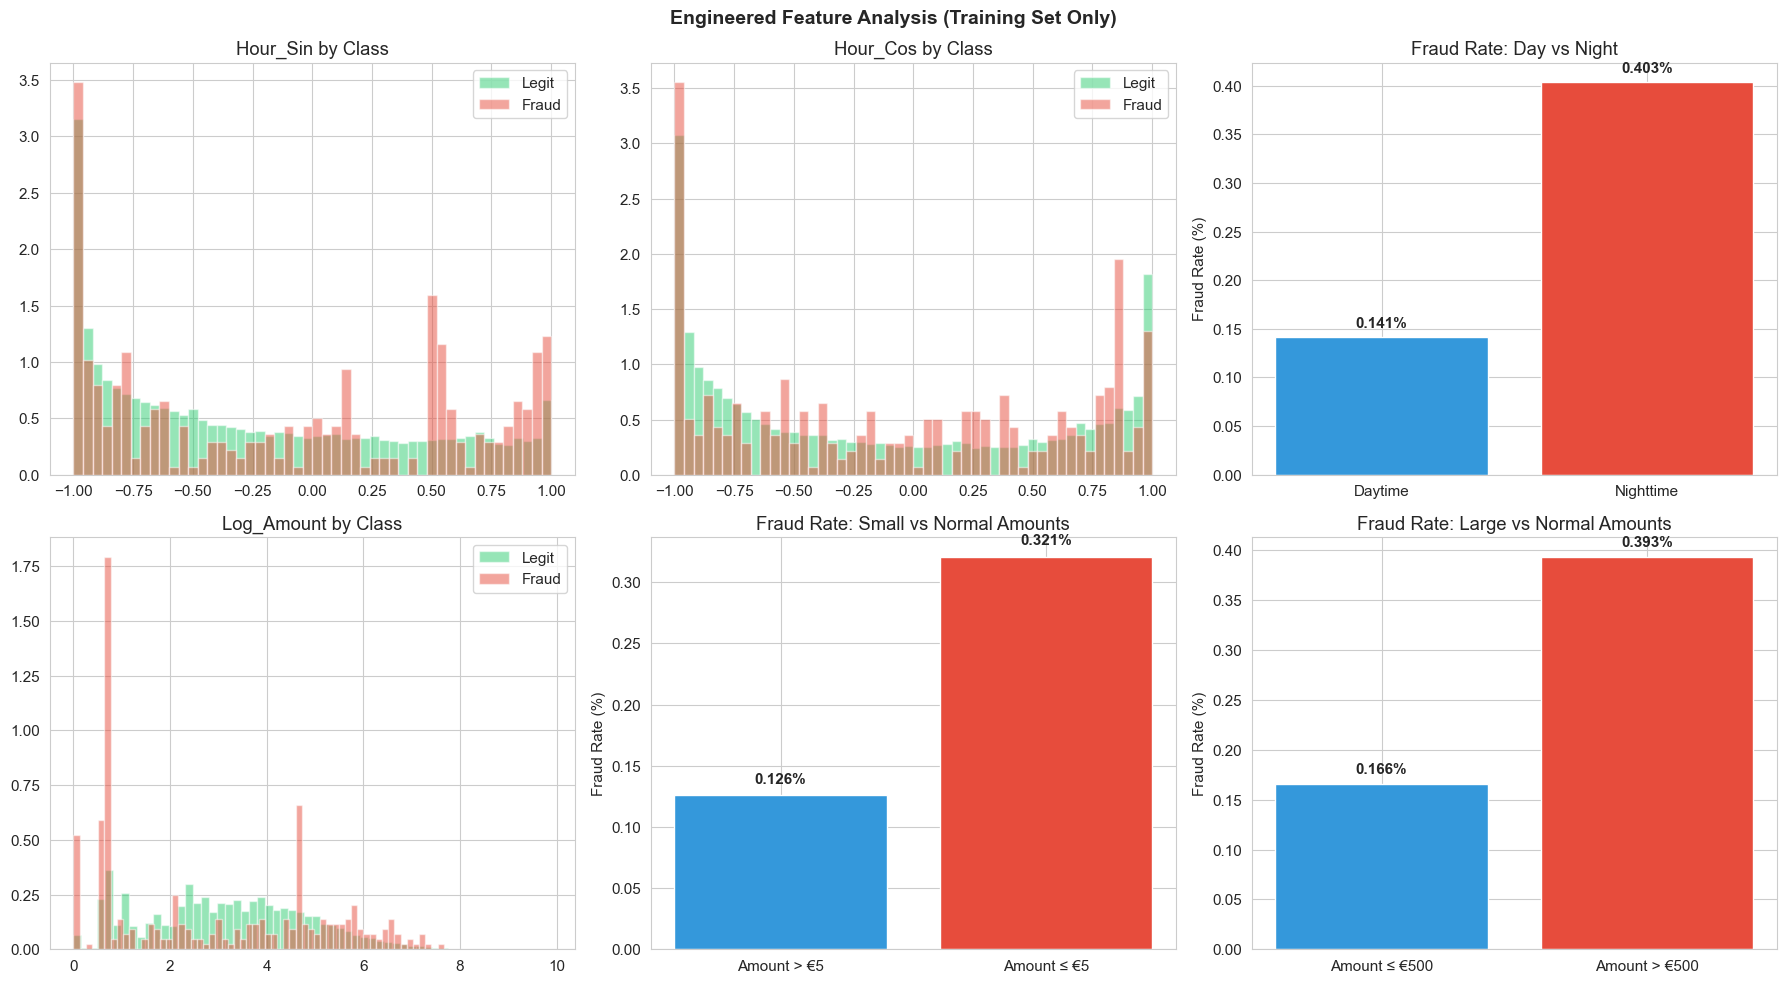

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for label, color, name in [(0, '#2ecc71', 'Legit'), (1, '#e74c3c', 'Fraud')]:
    subset = X_train_eng.loc[y_train == label]
    axes[0, 0].hist(subset['Hour_Sin'], bins=50, alpha=0.5, color=color,
                    label=name, density=True)
axes[0, 0].set_title('Hour_Sin by Class')
axes[0, 0].legend()

for label, color, name in [(0, '#2ecc71', 'Legit'), (1, '#e74c3c', 'Fraud')]:
    subset = X_train_eng.loc[y_train == label]
    axes[0, 1].hist(subset['Hour_Cos'], bins=50, alpha=0.5, color=color,
                    label=name, density=True)
axes[0, 1].set_title('Hour_Cos by Class')
axes[0, 1].legend()

night_data = pd.DataFrame({
    'Is_Night': X_train_eng['Is_Night'],
    'Class': y_train.values
})
night_fraud = night_data.groupby('Is_Night')['Class'].mean() * 100
axes[0, 2].bar(['Daytime', 'Nighttime'], night_fraud.values,
               color=['#3498db', '#e74c3c'])
axes[0, 2].set_ylabel('Fraud Rate (%)')
axes[0, 2].set_title('Fraud Rate: Day vs Night')
for i, v in enumerate(night_fraud.values):
    axes[0, 2].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

for label, color, name in [(0, '#2ecc71', 'Legit'), (1, '#e74c3c', 'Fraud')]:
    subset = X_train_eng.loc[y_train == label]
    axes[1, 0].hist(subset['Log_Amount'], bins=60, alpha=0.5, color=color,
                    label=name, density=True)
axes[1, 0].set_title('Log_Amount by Class')
axes[1, 0].legend()

small_data = pd.DataFrame({
    'Small': X_train_eng['Amount_Bin_Small'],
    'Class': y_train.values
})
small_fraud = small_data.groupby('Small')['Class'].mean() * 100
axes[1, 1].bar(['Amount > €5', 'Amount ≤ €5'], small_fraud.values,
               color=['#3498db', '#e74c3c'])
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].set_title('Fraud Rate: Small vs Normal Amounts')
for i, v in enumerate(small_fraud.values):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

large_data = pd.DataFrame({
    'Large': X_train_eng['Amount_Bin_Large'],
    'Class': y_train.values
})
large_fraud = large_data.groupby('Large')['Class'].mean() * 100
axes[1, 2].bar(['Amount ≤ €500', 'Amount > €500'], large_fraud.values,
               color=['#3498db', '#e74c3c'])
axes[1, 2].set_ylabel('Fraud Rate (%)')
axes[1, 2].set_title('Fraud Rate: Large vs Normal Amounts')
for i, v in enumerate(large_fraud.values):
    axes[1, 2].text(i, v + 0.01, f'{v:.3f}%', ha='center', fontweight='bold')

plt.suptitle('Engineered Feature Analysis (Training Set Only)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.3 Outlier Treatment: Winsorization of Amount

The V-features are PCA components and their outliers are meaningful (they
encode extreme transaction patterns). We only winsorize Amount because it
has extreme right skew (skewness 16) and the max (€25,691) is orders of
magnitude above the median (€22).

Winsorization caps are computed on training data only.

In [24]:
amount_lower = X_train_eng['Amount'].quantile(0.001)
amount_upper = X_train_eng['Amount'].quantile(0.999)

print(f"Amount winsorization caps (from training):")
print(f"  Lower (0.1th pct): €{amount_lower:.2f}")
print(f"  Upper (99.9th pct): €{amount_upper:.2f}")
print(f"  Training Amount range before: €{X_train_eng['Amount'].min():.2f} — "
      f"€{X_train_eng['Amount'].max():.2f}")

for data in [X_train_eng, X_val_eng, X_test_eng]:
    data['Amount'] = data['Amount'].clip(lower=amount_lower, upper=amount_upper)

print(f"  Training Amount range after:  €{X_train_eng['Amount'].min():.2f} — "
      f"€{X_train_eng['Amount'].max():.2f}")

print(f"\nAmount skewness before winsorization: "
      f"{skew(X_train['Amount']):.2f}")
print(f"Amount skewness after winsorization:  "
      f"{skew(X_train_eng['Amount']):.2f}")
print(f"Log_Amount skewness:                  "
      f"{skew(X_train_eng['Log_Amount']):.2f}")

Amount winsorization caps (from training):
  Lower (0.1th pct): €0.00
  Upper (99.9th pct): €2929.93
  Training Amount range before: €0.00 — €19656.53
  Training Amount range after:  €0.00 — €2929.93

Amount skewness before winsorization: 14.83
Amount skewness after winsorization:  6.81
Log_Amount skewness:                  0.16


## 4.4 Scaling Strategy

- V1–V28: Already standardized by PCA. No additional scaling needed.
- Amount: Needs scaling — it's on a completely different scale (€0–€25k)
  compared to V-features (centered at 0, std ≈ 1–5).
- Time: Raw seconds (0–172,000). Needs scaling.
- Engineered features: Log_Amount is on a moderate scale; Hour_Sin/Cos
  are bounded [-1, 1]; Is_Night and Amount_Bins are binary (0/1).

We use RobustScaler for Amount and Time because it is less sensitive
to outliers than StandardScaler. Scaler is fit on training data only.

In [25]:
features_to_scale = ['Amount', 'Time', 'Log_Amount']

scaler = RobustScaler()
X_train_eng[features_to_scale] = scaler.fit_transform(X_train_eng[features_to_scale])
X_val_eng[features_to_scale] = scaler.transform(X_val_eng[features_to_scale])
X_test_eng[features_to_scale] = scaler.transform(X_test_eng[features_to_scale])

print(f"\nScaled features: {features_to_scale}")
print(f"\nTraining statistics after scaling:")
for col in features_to_scale:
    print(f"  {col:15s}: mean={X_train_eng[col].mean():.4f}, "
          f"std={X_train_eng[col].std():.4f}, "
          f"median={X_train_eng[col].median():.4f}")

print(f"\nV-features (not scaled) — sample statistics:")
for col in ['V1', 'V14', 'V17']:
    print(f"  {col:15s}: mean={X_train_eng[col].mean():.4f}, "
          f"std={X_train_eng[col].std():.4f}")


Scaled features: ['Amount', 'Time', 'Log_Amount']

Training statistics after scaling:
  Amount         : mean=0.8980, std=2.9545, median=0.0000
  Time           : mean=0.1177, std=0.5576, median=0.0000
  Log_Amount     : mean=0.0070, std=0.6685, median=0.0000

V-features (not scaled) — sample statistics:
  V1             : mean=0.0004, std=1.9602
  V14            : mean=-0.0005, std=0.9574
  V17            : mean=-0.0000, std=0.8472


## 4.5 Near-Zero Variance Check

In [26]:
variance = X_train_eng.var().sort_values()
low_var = variance[variance < 1e-6]

print(f"Features with near-zero variance: {len(low_var)}")
if len(low_var) > 0:
    print(low_var.to_string())
    # Drop them
    drop_cols = low_var.index.tolist()
    X_train_eng.drop(columns=drop_cols, inplace=True)
    X_val_eng.drop(columns=drop_cols, inplace=True)
    X_test_eng.drop(columns=drop_cols, inplace=True)
    print(f"\nDropped: {drop_cols}")
else:
    print("All features have sufficient variance. ")

print(f"\nFinal feature count: {X_train_eng.shape[1]}")

Features with near-zero variance: 0
All features have sufficient variance. 

Final feature count: 36


## 4.6 Final Dataset Overview and Validation

In [27]:
print(f"\n  Training:   {X_train_eng.shape}")
print(f"  Validation: {X_val_eng.shape}")
print(f"  Test:       {X_test_eng.shape}")

print(f"\n  Missing values (train): {X_train_eng.isnull().sum().sum()}")
print(f"  Missing values (val):   {X_val_eng.isnull().sum().sum()}")
print(f"  Missing values (test):  {X_test_eng.isnull().sum().sum()}")

print(f"\n  Infinite values (train): {np.isinf(X_train_eng).sum().sum()}")

for data in [X_train_eng, X_val_eng, X_test_eng]:
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)

print(f"  After cleanup — Missing: {X_train_eng.isnull().sum().sum()}, "
      f"Inf: {np.isinf(X_train_eng).sum().sum()}")

print(f"\n  All dtypes numeric: "
      f"{all(X_train_eng.dtypes.apply(lambda x: np.issubdtype(x, np.number)))}")

print(f"\n  Features: {X_train_eng.columns.tolist()}")


  Training:   (199364, 36)
  Validation: (28481, 36)
  Test:       (56962, 36)

  Missing values (train): 0
  Missing values (val):   0
  Missing values (test):  0

  Infinite values (train): 0
  After cleanup — Missing: 0, Inf: 0

  All dtypes numeric: True

  Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour_Sin', 'Hour_Cos', 'Is_Night', 'Log_Amount', 'Amount_Bin_Small', 'Amount_Bin_Large']


In [28]:
feature_summary = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Mean': X_train_eng.mean().values,
    'Std': X_train_eng.std().values,
    'Min': X_train_eng.min().values,
    'Max': X_train_eng.max().values,
    'Skewness': X_train_eng.apply(skew).values,
    'Kurtosis': X_train_eng.apply(kurtosis).values,
    'Corr_with_Fraud': [np.corrcoef(X_train_eng[c], y_train)[0, 1]
                         for c in X_train_eng.columns]
}).set_index('Feature')

feature_summary['|Corr|'] = feature_summary['Corr_with_Fraud'].abs()
feature_summary = feature_summary.sort_values('|Corr|', ascending=False)

print(feature_summary.to_string())

                    Mean    Std      Min     Max  Skewness  Kurtosis  Corr_with_Fraud  |Corr|
Feature                                                                                      
V17              -0.0000 0.8472 -25.1628  9.2535   -3.7694   92.3857          -0.3322  0.3322
V14              -0.0005 0.9574 -19.2143 10.5268   -1.9958   24.1685          -0.3049  0.3049
V12               0.0018 0.9978 -18.4311  7.8484   -2.3003   20.6843          -0.2643  0.2643
V10              -0.0002 1.0894 -24.5883 23.7451    1.0768   33.3161          -0.2233  0.2233
V3               -0.0026 1.5176 -33.6810  9.3826   -2.1854   24.1460          -0.2024  0.2024
V16               0.0001 0.8735 -14.1299  7.0591   -1.1269    9.9152          -0.1986  0.1986
V7                0.0006 1.2182 -43.5572 36.6773   -1.1189   96.5084          -0.1985  0.1985
V11              -0.0008 1.0194  -4.6829 12.0189    0.3617    1.7401           0.1558  0.1558
V4               -0.0015 1.4162  -5.6832 16.8753    0.6824  

---
# 5. Comparison: Original vs Prepared Data

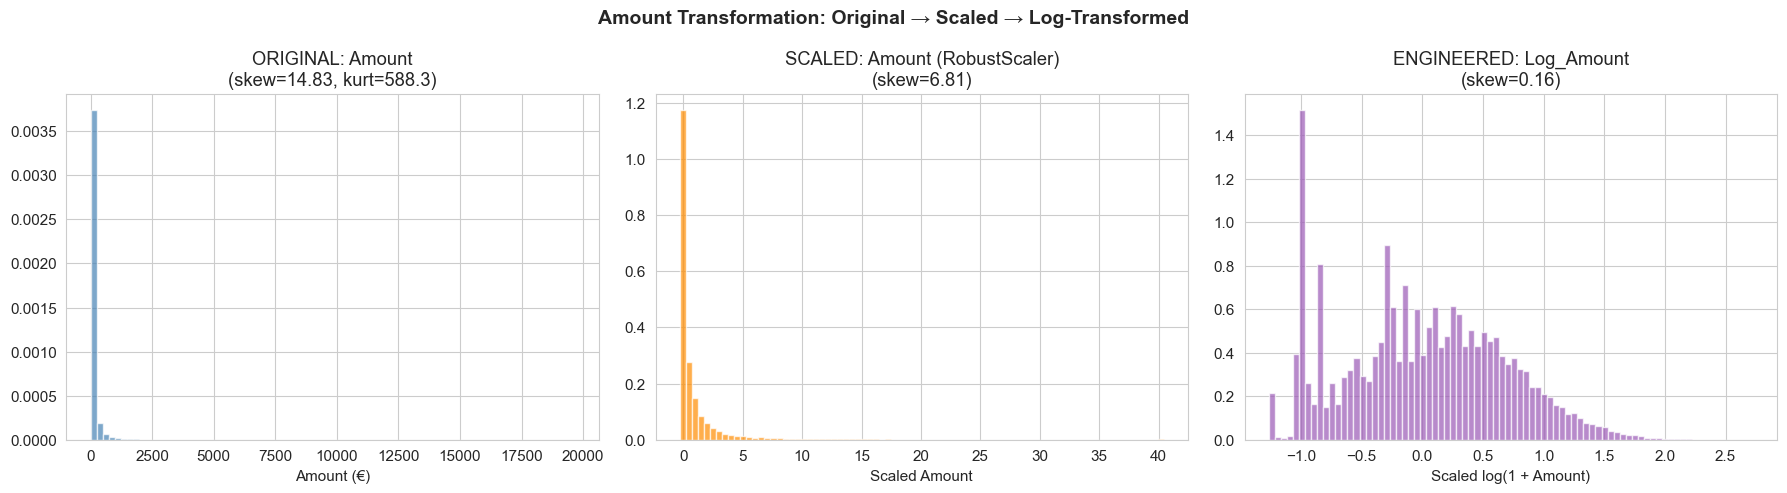

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(X_train['Amount'], bins=80, color='steelblue', alpha=0.7, density=True)
axes[0].set_title(f'ORIGINAL: Amount\n(skew={skew(X_train["Amount"]):.2f},'
                  f' kurt={kurtosis(X_train["Amount"]):.1f})')
axes[0].set_xlabel('Amount (€)')

axes[1].hist(X_train_eng['Amount'], bins=80, color='darkorange', alpha=0.7, density=True)
axes[1].set_title(f'SCALED: Amount (RobustScaler)\n'
                  f'(skew={skew(X_train_eng["Amount"]):.2f})')
axes[1].set_xlabel('Scaled Amount')

axes[2].hist(X_train_eng['Log_Amount'], bins=80, color='#9b59b6', alpha=0.7, density=True)
axes[2].set_title(f'ENGINEERED: Log_Amount\n'
                  f'(skew={skew(X_train_eng["Log_Amount"]):.2f})')
axes[2].set_xlabel('Scaled log(1 + Amount)')

plt.suptitle('Amount Transformation: Original → Scaled → Log-Transformed',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

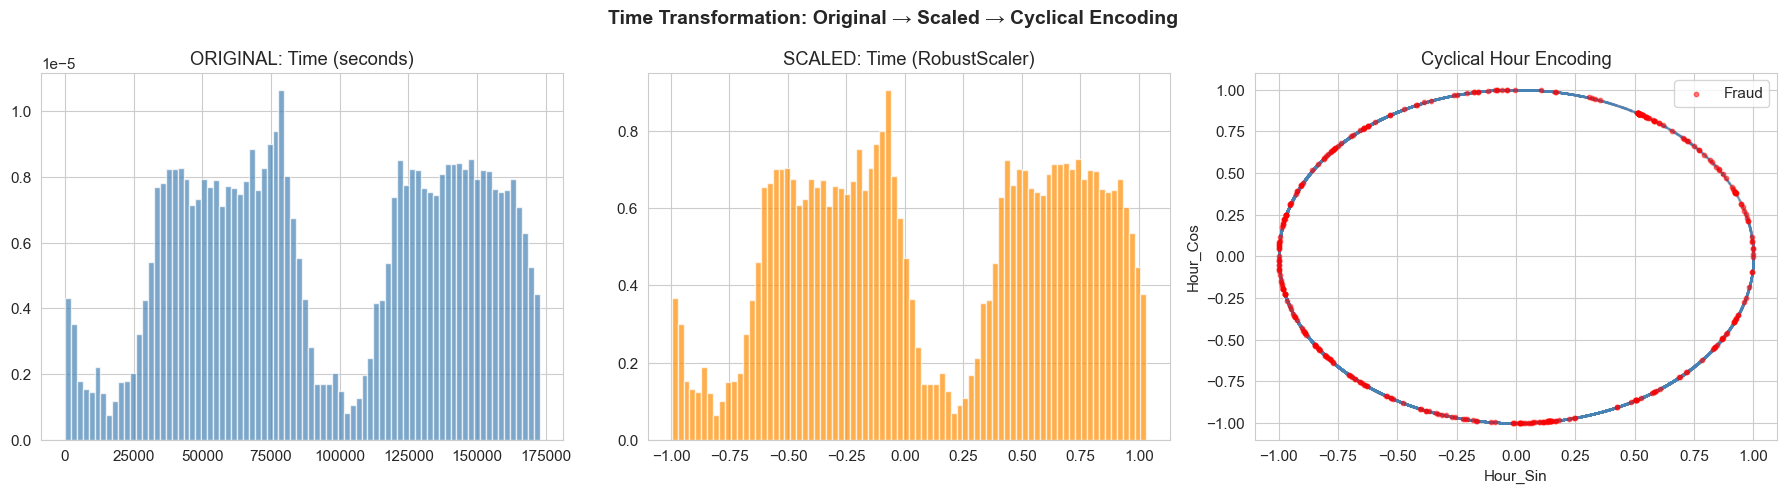

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(X_train['Time'], bins=80, color='steelblue', alpha=0.7, density=True)
axes[0].set_title('ORIGINAL: Time (seconds)')

axes[1].hist(X_train_eng['Time'], bins=80, color='darkorange', alpha=0.7, density=True)
axes[1].set_title('SCALED: Time (RobustScaler)')

axes[2].scatter(X_train_eng['Hour_Sin'], X_train_eng['Hour_Cos'],
                alpha=0.01, s=1, color='steelblue')
fraud_mask = y_train == 1
axes[2].scatter(X_train_eng.loc[fraud_mask, 'Hour_Sin'],
                X_train_eng.loc[fraud_mask, 'Hour_Cos'],
                alpha=0.5, s=10, color='red', label='Fraud')
axes[2].set_xlabel('Hour_Sin')
axes[2].set_ylabel('Hour_Cos')
axes[2].set_title('Cyclical Hour Encoding')
axes[2].legend()

plt.suptitle('Time Transformation: Original → Scaled → Cyclical Encoding',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

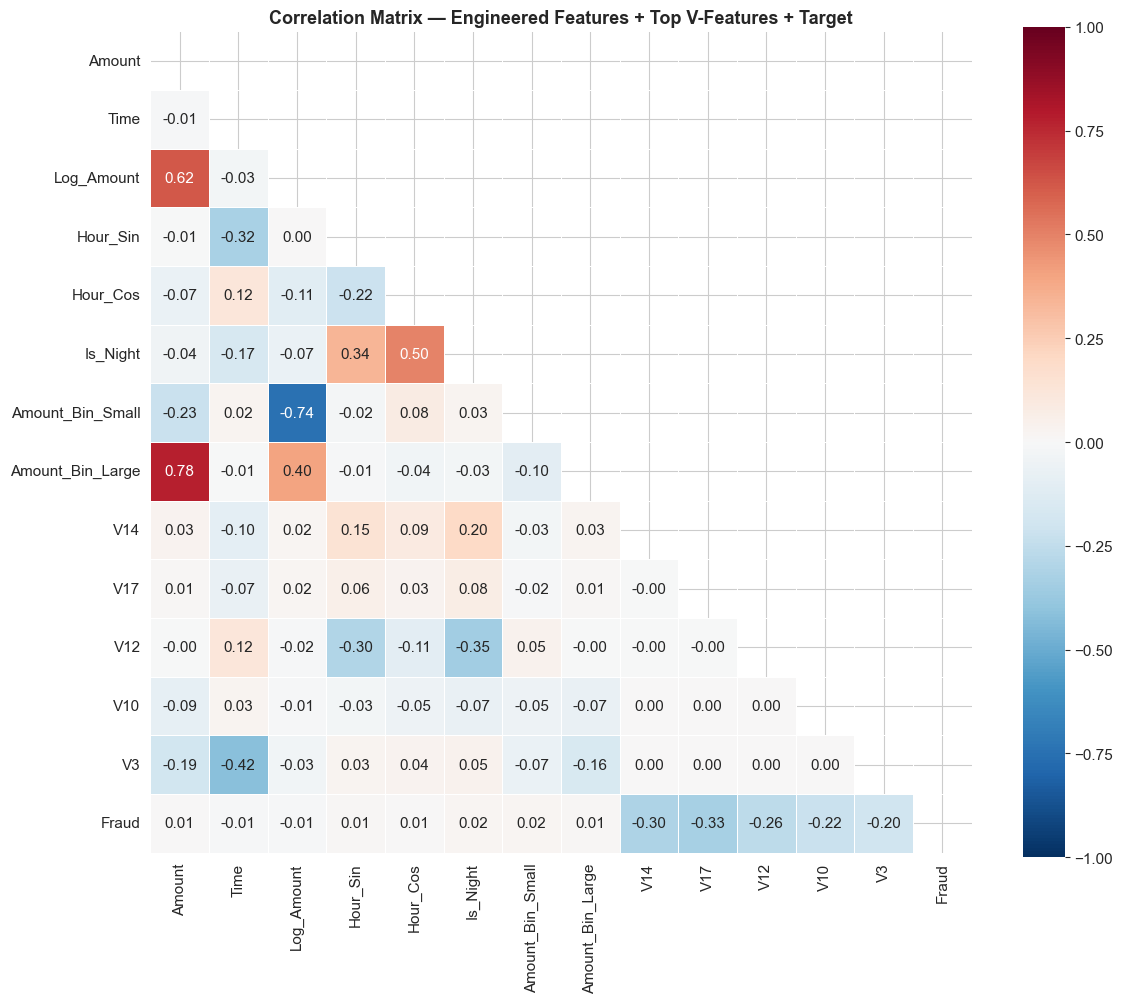

In [31]:
eng_features = ['Amount', 'Time', 'Log_Amount', 'Hour_Sin', 'Hour_Cos',
                'Is_Night', 'Amount_Bin_Small', 'Amount_Bin_Large']
eng_features = [f for f in eng_features if f in X_train_eng.columns]

top_v = ['V14', 'V17', 'V12', 'V10', 'V3']
plot_cols = eng_features + top_v

corr_final = X_train_eng[plot_cols].copy()
corr_final['Fraud'] = y_train.values
corr_matrix_final = corr_final.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix_final, dtype=bool))
sns.heatmap(corr_matrix_final, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, square=True)
plt.title('Correlation Matrix — Engineered Features + Top V-Features + Target',
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
# 6. Data Leakage Prevention Checklist

| Check | Status |
|-------|--------|
| Data split performed before any preprocessing | done |
| Winsorization caps computed on training data only | done |
| RobustScaler fit on training data only, then `.transform()` on val/test | done |
| Feature engineering uses only element-wise operations(no fitting) | done |
| Bin thresholds are fixed constants (€5, €500), not data-dependent | done |
| Target variable `Class` is never used as a feature or in any transformation | done |
| Fraud rates are consistent across train/val/test (~0.172%) | done |
| No future transactions leak into past (stratified random split) | done |
| V1–V28 PCA features are not re-scaled (already standardized) | done |


---
# 7. Data Ready for Modeling

The following objects are prepared and ready for model training:

| Object | Shape | Description |
|--------|-------|-------------|
| `X_train_eng` | (train_rows, features) | Training features, preprocessed |
| `y_train` | (train_rows,) | Training labels |
| `X_val_eng` | (val_rows, features) | Validation features, preprocessed |
| `y_val` | (val_rows,) | Validation labels |
| `X_test_eng` | (test_rows, features) | Test features, preprocessed (untouched until final eval) |
| `y_test` | (test_rows,) | Test labels |

### Preprocessing Summary

1. **Split:** 70 / 10 / 20 stratified split
2. **Feature engineering:** Hour_Sin, Hour_Cos, Is_Night, Log_Amount,
   Amount_Bin_Small, Amount_Bin_Large (6 new features)
3. **Winsorization:** Amount capped at 0.1st and 99.9th percentile (training)
4. **Scaling:** RobustScaler on Amount, Time, Log_Amount (fit on training only)
5. **V1–V28:** Untouched (PCA-standardized, orthogonal)
6. **No multicollinearity removal:** Not needed for PCA components
7. **No encoding:** All features are numeric

### Recommended Modeling Approach

- **Primary metric:** PR-AUC (Average Precision) — the 0.172% fraud rate makes
  accuracy meaningless and ROC-AUC misleadingly optimistic.
- **Class balancing:** Use `class_weight='balanced'` or SMOTE/undersampling.
- **Cross-validation:** StratifiedKFold (5 or 10 folds) to preserve class ratios.

---

### References

- Dal Pozzolo, A., O. Caelen, R. A. Johnson, and G. Bontempi. 2015. "Calibrating Probability with Undersampling for Unbalanced Classification." *IEEE Symposium Series on Computational Intelligence*, 159–166.
- LexisNexis Risk Solutions. 2023. *True Cost of Fraud Study*. Atlanta: LexisNexis.
- Nilson Report. 2022. "Global Card Fraud Losses." Issue 1209.
- Saito, T., and M. Rehmsmeier. 2015. "The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets." *PLoS ONE* 10 (3): e0118432.

# 8. Baseline Model: Majority Class Classifier

Before training any real model, we establish a floor. A classifier that always
predicts "legitimate" will achieve ~99.83% accuracy — proving accuracy is
meaningless for this problem.

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, average_precision_score, f1_score

dummy = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy.fit(X_train_eng, y_train)
y_pred_dummy = dummy.predict(X_val_eng)

print(classification_report(y_val, y_pred_dummy, target_names=['Legitimate', 'Fraud']))
print(f"Accuracy:  {dummy.score(X_val_eng, y_val):.4f}  ← looks great, means nothing")
print(f"F1 (Fraud): {f1_score(y_val, y_pred_dummy, pos_label=1):.4f}  ← zero")
print(f"PR-AUC:     {average_precision_score(y_val, dummy.predict_proba(X_val_eng)[:,1]):.4f}  ← baseline")

              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     28432
       Fraud       0.00      0.00      0.00        49

    accuracy                           1.00     28481
   macro avg       0.50      0.50      0.50     28481
weighted avg       1.00      1.00      1.00     28481

Accuracy:  0.9983  ← looks great, means nothing
F1 (Fraud): 0.0000  ← zero
PR-AUC:     0.0017  ← baseline


# 9. Random Forest Baseline with Cross-Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer

rf = Pipeline([
    ('clf', RandomForestClassifier(
        n_estimators=200, max_depth=15, class_weight='balanced',
        random_state=SEED, n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scoring = {
    'pr_auc': make_scorer(average_precision_score, needs_proba=True),
    'f1': make_scorer(f1_score, pos_label=1),
    'roc_auc': 'roc_auc',
    'recall': 'recall',
    'precision': 'precision'
}

cv_results = cross_validate(rf, X_train_eng, y_train, cv=cv,
                            scoring=scoring, return_train_score=True, n_jobs=-1)

print("Random Forest — 5-Fold Stratified CV \n")
for metric in ['pr_auc', 'f1', 'roc_auc', 'recall', 'precision']:
    train_scores = cv_results[f'train_{metric}']
    val_scores = cv_results[f'test_{metric}']
    print(f"  {metric:12s}  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}  |  "
          f"Val: {val_scores.mean():.4f} ± {val_scores.std():.4f}  |  "
          f"Gap: {train_scores.mean() - val_scores.mean():.4f}")

In [ ]:
rf.fit(X_train_eng, y_train)
y_val_proba_rf = rf.predict_proba(X_val_eng)[:, 1]
y_val_pred_rf = rf.predict(X_val_eng)

print(classification_report(y_val, y_val_pred_rf, target_names=['Legitimate', 'Fraud']))
print(f"PR-AUC:  {average_precision_score(y_val, y_val_proba_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_rf):.4f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, backend as K

tf.random.set_seed(SEED)

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_eng)
X_val_nn = scaler_nn.transform(X_val_eng)
X_test_nn = scaler_nn.transform(X_test_eng)

n_legit = (y_train == 0).sum()
n_fraud = (y_train == 1).sum()
weight_for_0 = 1.0 / n_legit * len(y_train) / 2.0
weight_for_1 = 1.0 / n_fraud * len(y_train) / 2.0
class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Class weights:")
print(f"  Legitimate (0): {weight_for_0:.4f}")
print(f"  Fraud (1):      {weight_for_1:.4f}")
print(f"  Ratio:          1 : {weight_for_1/weight_for_0:.0f}")
print(f"\nInput features: {X_train_nn.shape[1]}")

In [ ]:
def build_fraud_nn(input_dim, dropout_rate=0.3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate / 2),

        layers.Dense(16, activation='relu'),
        layers.Dropout(dropout_rate / 2),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.AUC(name='pr_auc', curve='PR'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision')
        ]
    )
    return model

model = build_fraud_nn(X_train_nn.shape[1])
model.summary()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics_to_plot = [('loss', 'Loss'), ('pr_auc', 'PR-AUC'),
                   ('recall', 'Recall'), ('precision', 'Precision')]

for ax, (metric, title) in zip(axes.flatten(), metrics_to_plot):
    ax.plot(history.history[metric], label=f'Train', linewidth=2)
    ax.plot(history.history[f'val_{metric}'], label=f'Validation', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.set_title(f'{title} Over Training')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Neural Network Training History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

best_epoch = np.argmax(history.history['val_pr_auc'])
print(f"\nBest epoch: {best_epoch + 1}")
print(f"  Val PR-AUC:    {history.history['val_pr_auc'][best_epoch]:.4f}")
print(f"  Val Recall:    {history.history['val_recall'][best_epoch]:.4f}")
print(f"  Val Precision: {history.history['val_precision'][best_epoch]:.4f}")

# 10. Neural Network for Fraud Detection
With only 0.172% fraud (345 training samples), standard binary cross-entropy struggles because the loss landscape is dominated by the 199k legitimate samples. We address this with three complementary strategies:
1. Focal Loss — down-weights easy/confident predictions and focuses learning on the hard, misclassified examples. Originally designed form object detection with extreme class imbalance (Lin et al., 2017).
2. Class Weights — inversely proportional to class frequency, making each fraud sample ~289× more influential than a legitimate one.
3. Threshold Optimization — the default 0.5 cutoff is arbitrary; we search for the threshold that maximizes F1 on the validation set.
We train two variants and keep the best:
- Model A: Standard BCE with class weights (the cell 55 architecture)
- Model B: Focal Loss with class weights + refined architecture

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, f1_score
)

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [53]:
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_eng)
X_val_nn   = scaler_nn.transform(X_val_eng)
X_test_nn  = scaler_nn.transform(X_test_eng)

n_legit = (y_train == 0).sum()
n_fraud = (y_train == 1).sum()
weight_for_0 = len(y_train) / (2.0 * n_legit)
weight_for_1 = len(y_train) / (2.0 * n_fraud)
class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Training samples — Legit: {n_legit:,}  Fraud: {n_fraud}")
print(f"Class weights    — 0: {weight_for_0:.4f}   1: {weight_for_1:.2f}")
print(f"Input features:    {X_train_nn.shape[1]}")

Training samples — Legit: 199,019  Fraud: 345
Class weights    — 0: 0.5009   1: 288.93
Input features:    36


 ── Focal Loss ──
Reduces the loss contribution from easy/well-classified examples,
forcing the model to focus on hard-to-classify fraud cases.
gamma=2 is the standard from the original paper, alpha handles class imbalance.

In [54]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

        bce_pos = -y_true * tf.math.log(y_pred)
        bce_neg = -(1 - y_true) * tf.math.log(1 - y_pred)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - p_t, gamma)

        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

        loss = alpha_t * focal_weight * (bce_pos + bce_neg)
        return tf.reduce_mean(loss)

    return focal_loss_fn

In [55]:
def build_model_bce(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(64, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.AUC(name='pr_auc', curve='PR'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision')
        ]
    )
    return model

In [56]:
model_a = build_model_bce(X_train_nn.shape[1])
model_a.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,529 (213.00 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [67]:
def build_model_focal(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(128, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        layers.Dense(64, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(16, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss=focal_loss(gamma=2.0, alpha=0.65),
        metrics=[
            keras.metrics.AUC(name='pr_auc', curve='PR'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision')
        ]
    )
    return model

In [68]:
model_b = build_model_focal(X_train_nn.shape[1])
model_b.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,169 (215.50 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [59]:
callbacks_a = [
    callbacks.EarlyStopping(
        monitor='val_pr_auc', patience=15, mode='max',
        restore_best_weights=True, verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc', factor=0.5, patience=5,
        mode='max', min_lr=1e-6, verbose=1
    )
]


In [60]:
history_a = model_a.fit(
    X_train_nn, y_train,
    validation_data=(X_val_nn, y_val),
    epochs=100,
    batch_size=2048,
    class_weight=class_weights,
    callbacks=callbacks_a,
    verbose=1
)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7023 - pr_auc: 0.0924 - precision: 0.0033 - recall: 0.8352 - roc_auc: 0.8248 - val_loss: 0.3283 - val_pr_auc: 0.6286 - val_precision: 0.0450 - val_recall: 0.8163 - val_roc_auc: 0.9524 - learning_rate: 0.0010
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3400 - pr_auc: 0.1659 - precision: 0.0088 - recall: 0.9235 - roc_auc: 0.9507 - val_loss: 0.2084 - val_pr_auc: 0.5602 - val_precision: 0.0625 - val_recall: 0.8367 - val_roc_auc: 0.9570 - learning_rate: 0.0010
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2783 - pr_auc: 0.2061 - precision: 0.0144 - recall: 0.9055 - roc_auc: 0.9646 - val_loss: 0.1709 - val_pr_auc: 0.5655 - val_precision: 0.0624 - val_recall: 0.8163 - val_roc_auc: 0.9394 - learning_rate: 0.0010
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2585 - pr_auc: 0.2312 - precision: 0.0192 - recall: 0.9202 - roc_auc: 0.9618 - val_loss: 0.1475 - val_pr_auc: 0.5920 - val_preci

In [69]:
callbacks_b = [
    callbacks.EarlyStopping(
        monitor='val_pr_auc', patience=25, mode='max',
        restore_best_weights=True, verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc', factor=0.5, patience=10,
        mode='max', min_lr=1e-6, verbose=1
    )
]


In [70]:
history_b = model_b.fit(
    X_train_nn, y_train,
    validation_data=(X_val_nn, y_val),
    epochs=100,
    batch_size=1024,
    class_weight={0: 1.0, 1: 50.0},
    callbacks=callbacks_b,
    verbose=1
)

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.1144 - pr_auc: 0.0909 - precision: 0.0038 - recall: 0.7399 - roc_auc: 0.7741 - val_loss: 0.0398 - val_pr_auc: 0.5629 - val_precision: 0.7941 - val_recall: 0.5510 - val_roc_auc: 0.8430 - learning_rate: 5.0000e-04
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0392 - pr_auc: 0.0726 - precision: 0.0181 - recall: 0.4156 - roc_auc: 0.7399 - val_loss: 0.0198 - val_pr_auc: 0.6011 - val_precision: 0.7895 - val_recall: 0.3061 - val_roc_auc: 0.8805 - learning_rate: 5.0000e-04
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0216 - pr_auc: 0.1942 - precision: 0.0514 - recall: 0.4752 - roc_auc: 0.8068 - val_loss: 0.0115 - val_pr_auc: 0.6318 - val_precision: 0.8400 - val_recall: 0.4286 - val_roc_auc: 0.8936 - learning_rate: 5.0000e-04
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0148 - pr_auc: 0.2596 - precision: 0.0950 - recall: 0.6384 - roc_auc: 0.8532 - val_loss: 0.0091 - val_pr_auc

## Training curves side by side

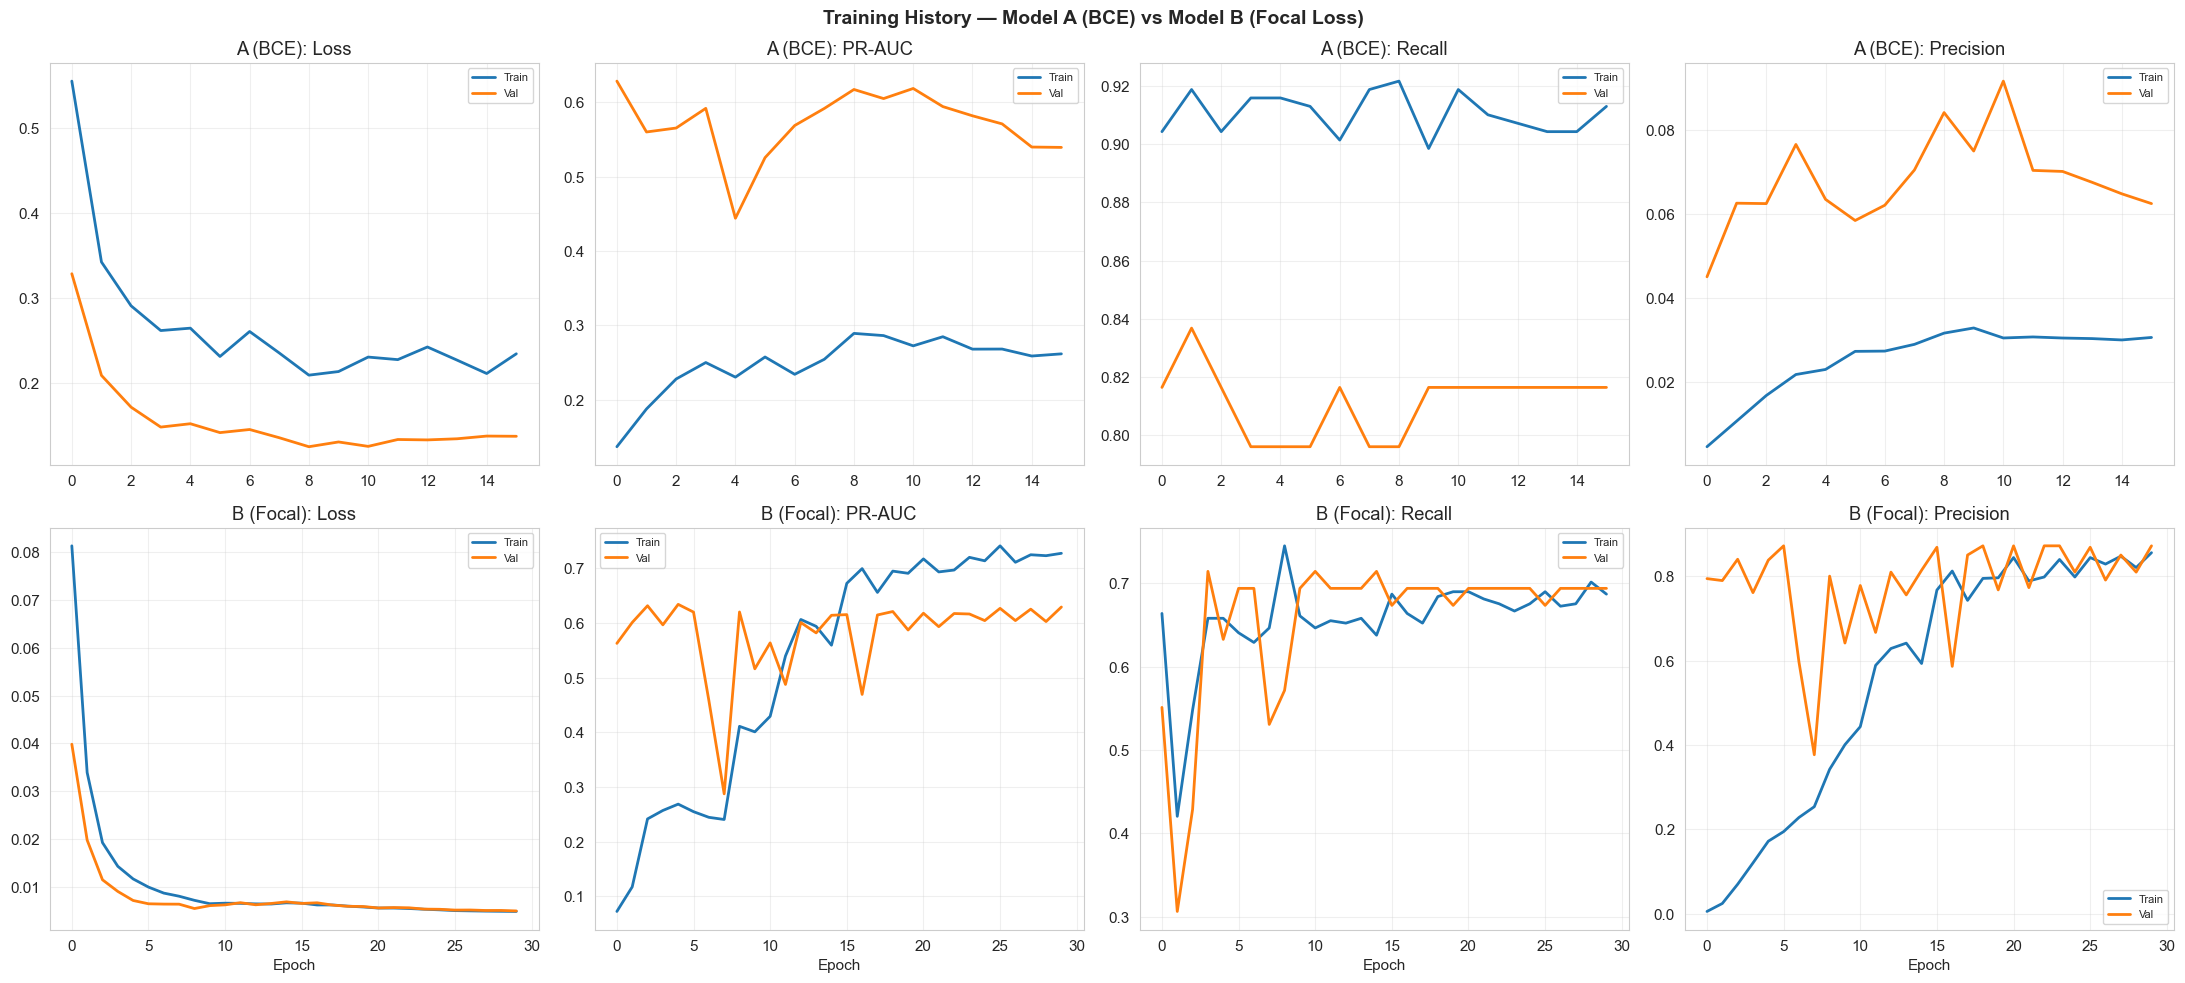

In [71]:
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
metrics_to_plot = [('loss', 'Loss'), ('pr_auc', 'PR-AUC'),
                   ('recall', 'Recall'), ('precision', 'Precision')]

for col, (metric, title) in enumerate(metrics_to_plot):
    axes[0, col].plot(history_a.history[metric], label='Train', linewidth=2)
    axes[0, col].plot(history_a.history[f'val_{metric}'], label='Val', linewidth=2)
    axes[0, col].set_title(f'A (BCE): {title}')
    axes[0, col].legend(fontsize=8)
    axes[0, col].grid(True, alpha=0.3)

    axes[1, col].plot(history_b.history[metric], label='Train', linewidth=2)
    axes[1, col].plot(history_b.history[f'val_{metric}'], label='Val', linewidth=2)
    axes[1, col].set_title(f'B (Focal): {title}')
    axes[1, col].set_xlabel('Epoch')
    axes[1, col].legend(fontsize=8)
    axes[1, col].grid(True, alpha=0.3)

plt.suptitle('Training History — Model A (BCE) vs Model B (Focal Loss)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [72]:
for name, hist in [('A (BCE)', history_a), ('B (Focal)', history_b)]:
    best_ep = np.argmax(hist.history['val_pr_auc'])
    print(f"\nModel {name} — Best epoch: {best_ep + 1}")
    print(f"  Val PR-AUC:    {hist.history['val_pr_auc'][best_ep]:.4f}")
    print(f"  Val Recall:    {hist.history['val_recall'][best_ep]:.4f}")
    print(f"  Val Precision: {hist.history['val_precision'][best_ep]:.4f}")


Model A (BCE) — Best epoch: 1
  Val PR-AUC:    0.6286
  Val Recall:    0.8163
  Val Precision: 0.0450

Model B (Focal) — Best epoch: 5
  Val PR-AUC:    0.6343
  Val Recall:    0.6327
  Val Precision: 0.8378


In [73]:
y_val_proba_a = model_a.predict(X_val_nn, verbose=0).ravel()
y_val_proba_b = model_b.predict(X_val_nn, verbose=0).ravel()

pr_auc_a = average_precision_score(y_val, y_val_proba_a)
pr_auc_b = average_precision_score(y_val, y_val_proba_b)
roc_auc_a = roc_auc_score(y_val, y_val_proba_a)
roc_auc_b = roc_auc_score(y_val, y_val_proba_b)

print(f"Model A (BCE)   — Val PR-AUC: {pr_auc_a:.4f}   ROC-AUC: {roc_auc_a:.4f}")
print(f"Model B (Focal) — Val PR-AUC: {pr_auc_b:.4f}   ROC-AUC: {roc_auc_b:.4f}")

Model A (BCE)   — Val PR-AUC: 0.6044   ROC-AUC: 0.9525
Model B (Focal) — Val PR-AUC: 0.6390   ROC-AUC: 0.9292


# SMOTE


In [76]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, f1_score
)


In [77]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [78]:
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_eng)
X_val_nn   = scaler_nn.transform(X_val_eng)
X_test_nn  = scaler_nn.transform(X_test_eng)

In [79]:
smote = SMOTE(
    sampling_strategy=0.1,
    random_state=SEED,
    k_neighbors=5
)

In [80]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_nn, y_train)

n_original_fraud = (y_train == 1).sum()
n_smote_fraud = (y_train_smote == 1).sum()
n_smote_legit = (y_train_smote == 0).sum()

In [81]:
def build_model_smote(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Dense(64, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='binary_crossentropy',    # plain BCE — SMOTE handles imbalance
        metrics=[
            keras.metrics.AUC(name='pr_auc', curve='PR'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.Precision(name='precision')
        ]
    )
    return model

In [82]:
model_smote = build_model_smote(X_train_smote.shape[1])
model_smote.summary()

callbacks_smote = [
    callbacks.EarlyStopping(
        monitor='val_pr_auc', patience=20, mode='max',
        restore_best_weights=True, verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc', factor=0.5, patience=8,
        mode='max', min_lr=1e-6, verbose=1
    )
]

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 256)            │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,529 (213.00 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [83]:
history_smote = model_smote.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val_nn, y_val),
    epochs=150,
    batch_size=1024,
    callbacks=callbacks_smote,
    verbose=1
)


Epoch 1/150
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.3083 - pr_auc: 0.8231 - precision: 0.4966 - recall: 0.8378 - roc_auc: 0.9179 - val_loss: 0.0322 - val_pr_auc: 0.6302 - val_precision: 0.2077 - val_recall: 0.7755 - val_roc_auc: 0.9313 - learning_rate: 5.0000e-04
Epoch 2/150
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.3168 - pr_auc: 0.7576 - precision: 0.5258 - recall: 0.8516 - roc_auc: 0.9441 - val_loss: 0.0308 - val_pr_auc: 0.6183 - val_precision: 0.2229 - val_recall: 0.7959 - val_roc_auc: 0.9127 - learning_rate: 5.0000e-04
Epoch 3/150
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2131 - pr_auc: 0.8175 - precision: 0.7101 - recall: 0.8445 - roc_auc: 0.9480 - val_loss: 0.0262 - val_pr_auc: 0.6319 - val_precision: 0.2635 - val_recall: 0.7959 - val_roc_auc: 0.9141 - learning_rate: 5.0000e-04
Epoch 4/150
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1459 - pr_auc: 0.8719 - precision: 0.8368 - recall: 0.8453 - roc_auc: 0.9515 - val_loss: 0.0199 - val_pr_auc

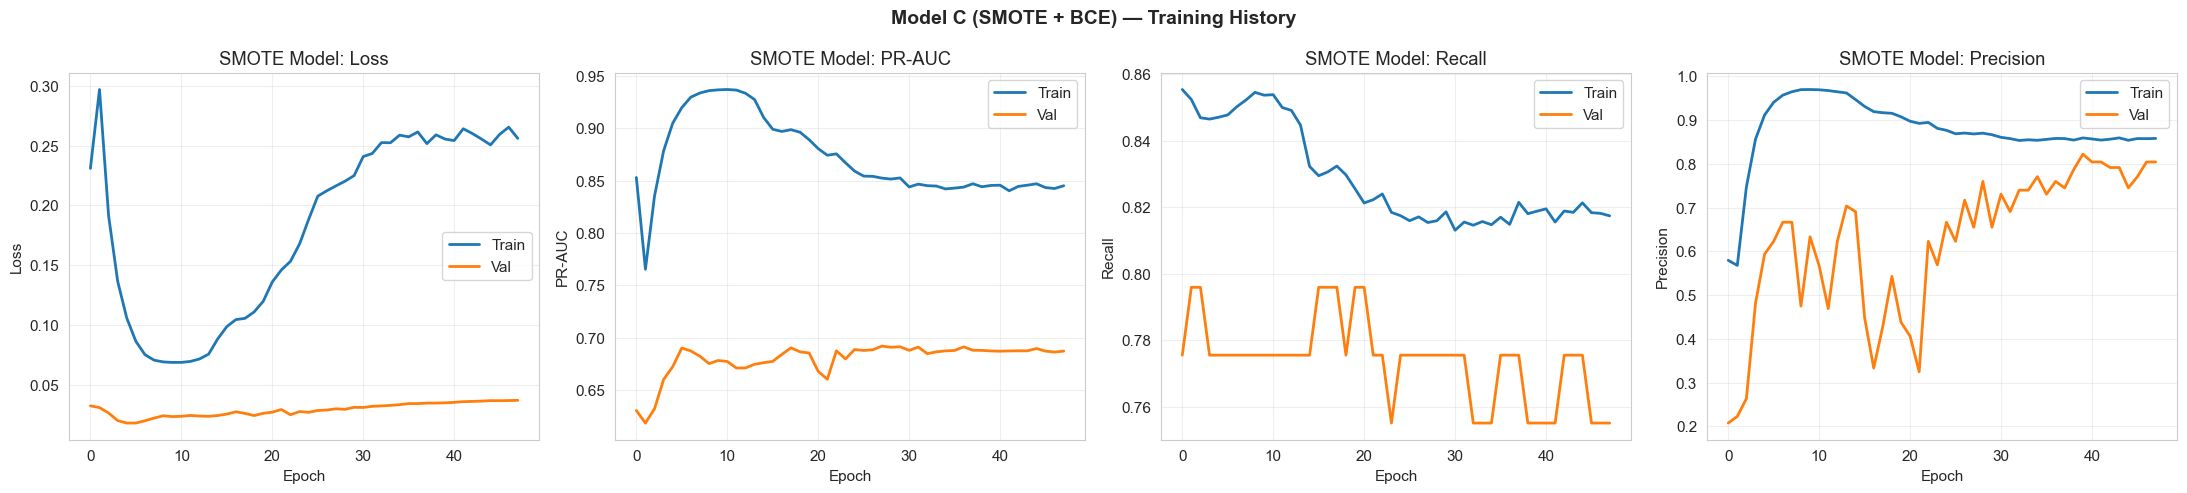


Best epoch: 28
  Val PR-AUC:    0.6918
  Val Recall:    0.7755
  Val Precision: 0.6552


In [84]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
metrics_to_plot = [('loss', 'Loss'), ('pr_auc', 'PR-AUC'),
                   ('recall', 'Recall'), ('precision', 'Precision')]

for ax, (metric, title) in zip(axes, metrics_to_plot):
    ax.plot(history_smote.history[metric], label='Train', linewidth=2)
    ax.plot(history_smote.history[f'val_{metric}'], label='Val', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.set_title(f'SMOTE Model: {title}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Model C (SMOTE + BCE) — Training History',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

best_ep = np.argmax(history_smote.history['val_pr_auc'])
print(f"\nBest epoch: {best_ep + 1}")
print(f"  Val PR-AUC:    {history_smote.history['val_pr_auc'][best_ep]:.4f}")
print(f"  Val Recall:    {history_smote.history['val_recall'][best_ep]:.4f}")
print(f"  Val Precision: {history_smote.history['val_precision'][best_ep]:.4f}")

In [85]:
y_val_proba_smote = model_smote.predict(X_val_nn, verbose=0).ravel()

pr_auc_smote = average_precision_score(y_val, y_val_proba_smote)
roc_auc_smote = roc_auc_score(y_val, y_val_proba_smote)
print(f"Model C (SMOTE) — Val PR-AUC: {pr_auc_smote:.4f}   ROC-AUC: {roc_auc_smote:.4f}")

Model C (SMOTE) — Val PR-AUC: 0.6735   ROC-AUC: 0.9561


In [86]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba_smote)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

In [88]:
print(f"\nThreshold optimization:")
print(f"  Default (0.5)           - F1 = {f1_score(y_val, (y_val_proba_smote >= 0.5).astype(int)):.4f}")
print(f"  Optimal ({best_threshold:.4f})  - F1 = {f1_scores[best_idx]:.4f}")
print(f"  Precision = {precisions[best_idx]:.4f}, Recall = {recalls[best_idx]:.4f}")



Threshold optimization:
  Default (0.5)           - F1 = 0.7103
  Optimal (0.8949)  - F1 = 0.8043
  Precision = 0.8605, Recall = 0.7551


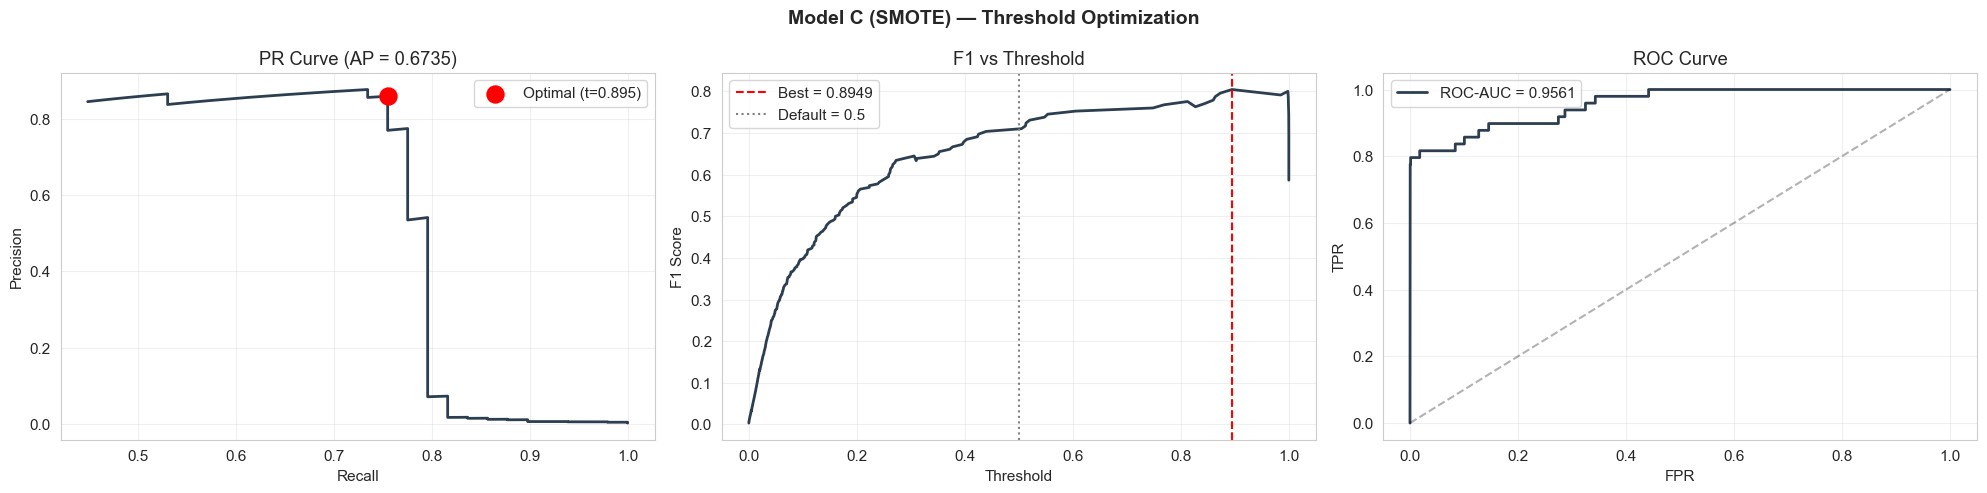

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(recalls[:-1], precisions[:-1], linewidth=2, color='#2c3e50')
axes[0].scatter(recalls[best_idx], precisions[best_idx],
                s=150, c='red', zorder=5, label=f'Optimal (t={best_threshold:.3f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'PR Curve (AP = {pr_auc_smote:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(thresholds, f1_scores, linewidth=2, color='#2c3e50')
axes[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'Best = {best_threshold:.4f}')
axes[1].axvline(x=0.5, color='gray', linestyle=':', label='Default = 0.5')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

fpr, tpr, _ = roc_curve(y_val, y_val_proba_smote)
axes[2].plot(fpr, tpr, linewidth=2, color='#2c3e50',
             label=f'ROC-AUC = {roc_auc_smote:.4f}')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[2].set_xlabel('FPR')
axes[2].set_ylabel('TPR')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle(f'Model C (SMOTE) — Threshold Optimization',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


Classification Report (threshold = 0.8949):
              precision    recall  f1-score   support

  Legitimate     0.9996    0.9998    0.9997     28432
       Fraud     0.8605    0.7551    0.8043        49

    accuracy                         0.9994     28481
   macro avg     0.9300    0.8774    0.9020     28481
weighted avg     0.9993    0.9994    0.9993     28481

  Fraud caught:    37/49 (75.5%)
  False alarms:    6/28432 (0.021%)


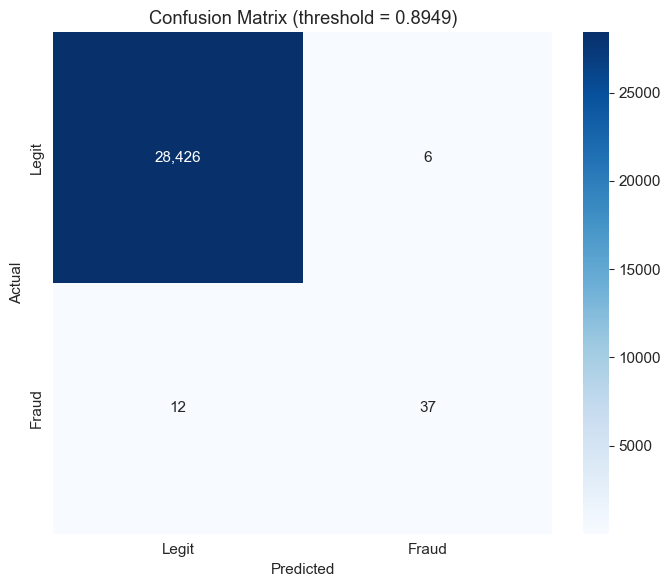

In [90]:
y_val_pred_smote = (y_val_proba_smote >= best_threshold).astype(int)

print(f"\nClassification Report (threshold = {best_threshold:.4f}):")
print(classification_report(y_val, y_val_pred_smote,
                            target_names=['Legitimate', 'Fraud'], digits=4))

cm = confusion_matrix(y_val, y_val_pred_smote)
tn, fp, fn, tp = cm.ravel()
print(f"  Fraud caught:    {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}%)")
print(f"  False alarms:    {fp}/{fp+tn} ({fp/(fp+tn)*100:.3f}%)")

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
            xticklabels=['Legit', 'Fraud'],
            yticklabels=['Legit', 'Fraud'], ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (threshold = {best_threshold:.4f})')
plt.tight_layout()
plt.show()


# 11. XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful ensemble method that builds trees sequentially,
each correcting errors from the previous one. It handles class imbalance natively via `scale_pos_weight`
and typically outperforms Random Forest on structured/tabular data.

We use the same engineered features and train/validation split to keep comparisons fair.

In [ ]:
import xgboost as xgb
import time
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_auc_score, f1_score
)

# Calculate scale_pos_weight for class imbalance
scale_pos = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
print(f"scale_pos_weight: {scale_pos:.2f}  (ratio of legit to fraud)")

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=SEED,
    n_jobs=-1
)

t0 = time.time()
xgb_model.fit(X_train_eng, y_train)
xgb_time = time.time() - t0

print(f"Training time: {xgb_time:.2f}s")

In [ ]:
y_val_proba_xgb = xgb_model.predict_proba(X_val_eng)[:, 1]
y_val_pred_xgb = xgb_model.predict(X_val_eng)

print(classification_report(y_val, y_val_pred_xgb,
                            target_names=['Legitimate', 'Fraud'], digits=4))
print(f"PR-AUC:  {average_precision_score(y_val, y_val_proba_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_val_proba_xgb):.4f}")
print(f"F1 (Fraud): {f1_score(y_val, y_val_pred_xgb, pos_label=1):.4f}")

In [ ]:
# Threshold optimization for XGBoost
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_val, y_val_proba_xgb)
f1_scores_xgb = 2 * (precisions_xgb[:-1] * recalls_xgb[:-1]) / (precisions_xgb[:-1] + recalls_xgb[:-1] + 1e-8)
best_idx_xgb = np.argmax(f1_scores_xgb)
best_threshold_xgb = thresholds_xgb[best_idx_xgb]

print(f"Optimal threshold: {best_threshold_xgb:.4f}")
print(f"  F1 at optimal:   {f1_scores_xgb[best_idx_xgb]:.4f}")
print(f"  Precision:       {precisions_xgb[best_idx_xgb]:.4f}")
print(f"  Recall:          {recalls_xgb[best_idx_xgb]:.4f}")

In [ ]:
# Precision-Recall curve and confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(recalls_xgb[:-1], precisions_xgb[:-1], linewidth=2, color='#2c3e50')
axes[0].scatter(recalls_xgb[best_idx_xgb], precisions_xgb[best_idx_xgb],
                s=150, c='red', zorder=5, label=f'Optimal (t={best_threshold_xgb:.3f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('XGBoost — Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(thresholds_xgb, f1_scores_xgb, linewidth=2, color='#e74c3c')
axes[1].axvline(best_threshold_xgb, color='gray', linestyle='--', label=f't={best_threshold_xgb:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('XGBoost — F1 vs Threshold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

y_val_pred_xgb_opt = (y_val_proba_xgb >= best_threshold_xgb).astype(int)
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb_opt)
import seaborn as sns
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title(f'XGBoost Confusion Matrix (t={best_threshold_xgb:.3f})')

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance from XGBoost
xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train_eng.columns
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
xgb_importance.head(20).plot(kind='barh', ax=ax, color='#e74c3c', edgecolor='black')
ax.set_title('XGBoost — Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('
Top 10 features (XGBoost):')
for feat, imp in xgb_importance.head(10).items():
    print(f'  {feat:>20s}: {imp:.4f}')